# Importaciones

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
path = 'D:/uni/4º año/TFG-GitHub/GII_O_MA_22.07/DatosValidados/SoloDatosValidos_Sensor3.csv'
datos = pd.read_csv(path, index_col=0)

# Pillamos datos cada hora para hacer predicciones por hora

# Datos sin salto con media
date_time = pd.to_datetime(datos.pop('fecha'), format='%Y/%m/%d, %H:%M:%S')
datos = datos.groupby(np.arange(len(datos))//12).mean()
date_time = date_time[::12]
date_time = date_time[:-2500]
datos
datos = datos[:-2500]

datos.pop('h_C')
datos.pop('h_L')
datos.pop('pluv_delta')
datos.pop('t_C_var')
datos.pop('t_L_var')
datos.pop('h_C_var')
datos.pop('h_L_var')
datos.pop('t_ext')
datos.pop('h_ext')
# datos.pop('t_L_cal')
# datos.pop('h_C_cal')
# datos.pop('h_L_cal')

0       30.483333
1       34.716667
2       49.708333
3       93.125000
4       98.250000
          ...    
2982    32.216667
2983    29.791667
2984    31.025000
2985    33.016667
2986    33.708333
Name: h_ext, Length: 2987, dtype: float64

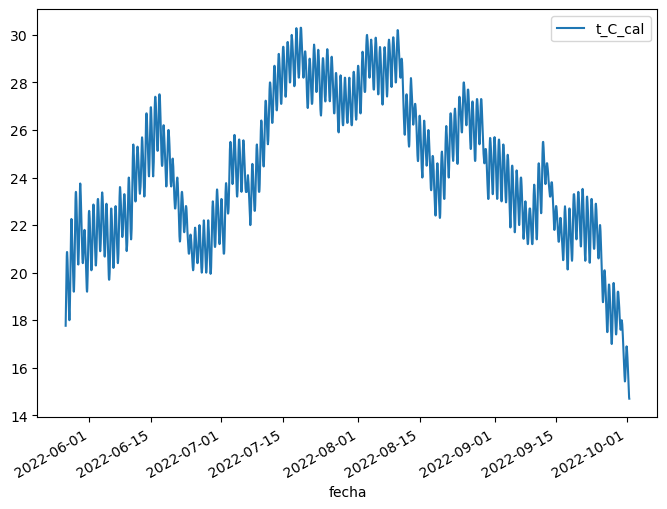

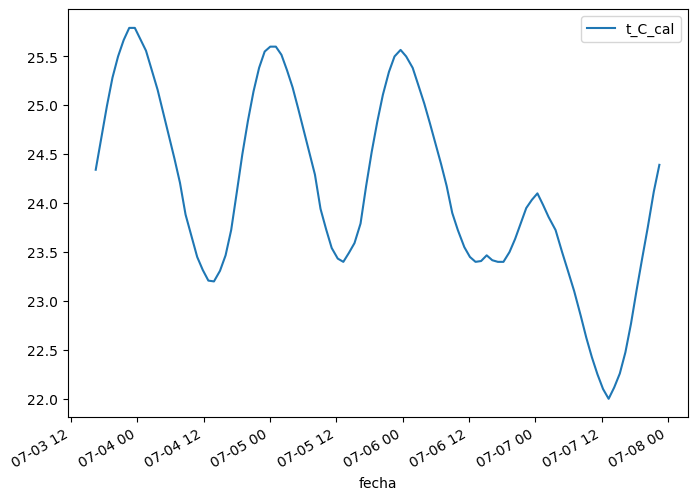

In [3]:
plot_cols = ['t_C_cal']
plot_features = datos[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = datos[plot_cols][2000:2100]
plot_features.index = date_time[2000:2100]
_ = plot_features.plot(subplots=True)

In [4]:
datos.describe().transpose()

count       mean       std        min        25%        50%  \
t_C_cal  2987.0  24.352184  3.061159  14.700000  22.095833  24.183333   
h_C_cal  2987.0  36.133655  2.697641  32.030000  33.820000  36.120000   
t_L_cal  2987.0  24.314223  2.691234  16.908333  22.212500  24.258333   
h_L_cal  2987.0  21.564203  0.810864  20.557500  21.080000  21.410000   
mes      2987.0   7.404866  1.206999   5.000000   6.000000   7.000000   
hora     2987.0  11.512052  6.643118   0.000000   5.750000  11.500000   

               75%    max  
t_C_cal  26.912500  30.30  
h_C_cal  37.390000  44.79  
t_L_cal  26.795833  29.10  
h_L_cal  21.740000  26.82  
mes       8.000000  10.00  
hora     17.250000  23.00

In [5]:
datos_norm = datos.copy()

for columna in datos_norm.columns:
    datos_norm[columna] = (datos_norm[columna] - datos_norm[columna].min()) / (datos_norm[columna].max() - datos_norm[columna].min())

datos_norm

t_C_cal   h_C_cal   t_L_cal   h_L_cal  mes      hora
0     0.000000  0.014107  0.000000  0.048303  1.0  0.528986
1     0.002671  0.007053  0.008202  0.061477  1.0  0.485507
2     0.011218  0.002351  0.015721  0.048303  1.0  0.442029
3     0.032051  0.028409  0.026658  0.052695  1.0  0.380435
4     0.046474  0.035528  0.034860  0.061477  1.0  0.329710
...        ...       ...       ...       ...  ...       ...
2982  0.334936  0.933386  0.133971  0.973653  0.0  0.811594
2983  0.302885  0.912160  0.111415  0.995609  0.0  0.764493
2984  0.267094  0.895507  0.100478  0.995609  0.0  0.721014
2985  0.228632  0.869188  0.092960  0.995609  0.0  0.677536
2986  0.196581  0.878788  0.089542  1.000000  0.0  0.634058

[2987 rows x 6 columns]

In [6]:
column_indices = {name: i for i, name in enumerate(datos_norm.columns)}

n = len(datos_norm)
train_df = datos_norm[0:int(n*0.7)]
val_df = datos_norm[int(n*0.7):int(n*0.9)]
test_df = datos_norm[int(n*0.9):]

num_features = datos_norm.shape[1]

In [7]:
# datos_norm = datos.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=datos_norm)
# _ = ax.set_xticklabels(datos.keys(), rotation=90)

# Generación de ventanas de datos

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['t_C_cal'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['t_C_cal']

In [10]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['t_C_cal'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['t_C_cal']

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


In [13]:
w2.example = example_inputs, example_labels

In [14]:
def plot(self, model=None, plot_col='t_C_cal', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

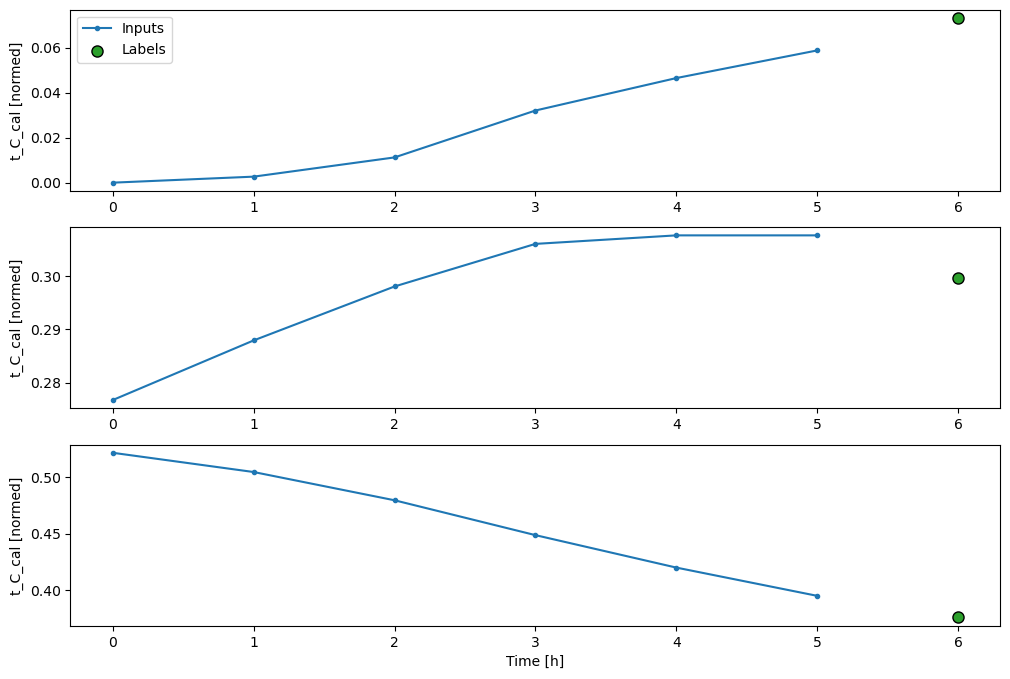

In [15]:
w2.plot()

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['t_C_cal'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['t_C_cal']

# Modelos de un solo paso

## Baseline

In [19]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [20]:
baseline = Baseline(label_index=column_indices['t_C_cal'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

19/19 [==============================] - 0s 1ms/step - loss: 2.0512e-04 - mean_squared_error: 2.0512e-04


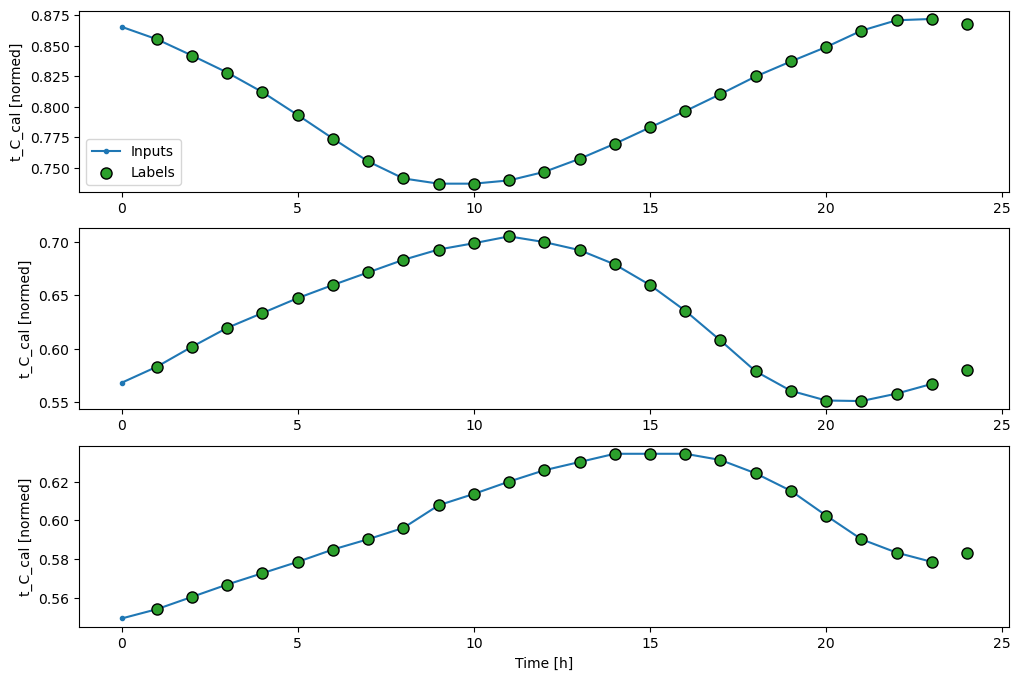

In [21]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['t_C_cal'])

wide_window.plot()

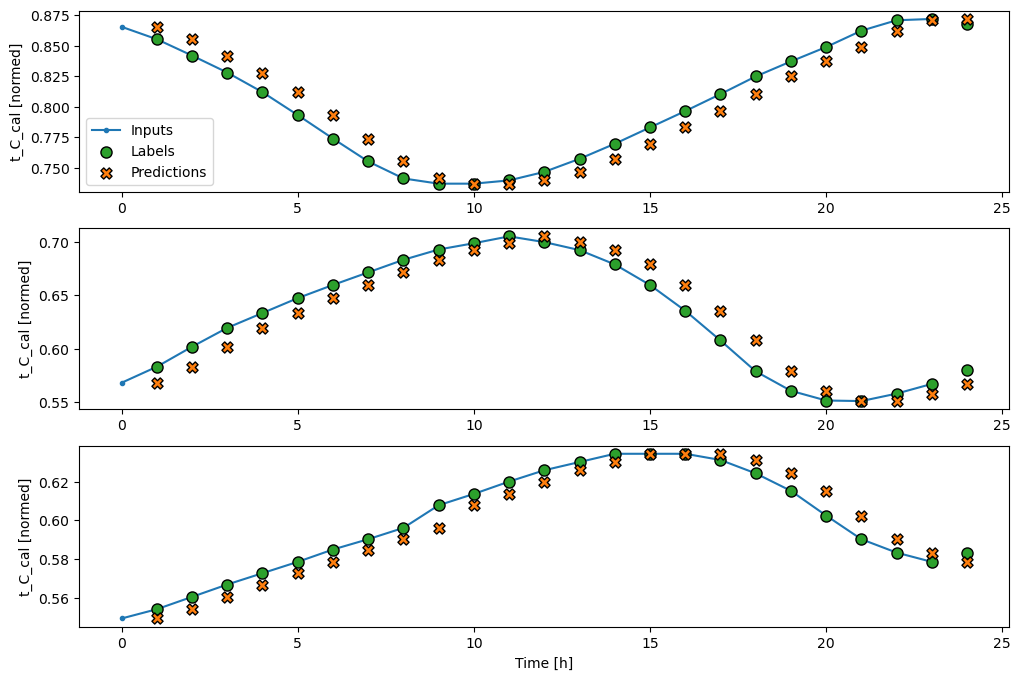

In [22]:
wide_window.plot(baseline)

## Lineal

In [23]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10)
])

In [24]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [25]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
66/66 [==============================] - 1s 4ms/step - loss: 0.5138 - mean_squared_error: 0.5138 - val_loss: 0.2787 - val_mean_squared_error: 0.2787
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.3052 - mean_squared_error: 0.3052 - val_loss: 0.1644 - val_mean_squared_error: 0.1644
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.1828 - mean_squared_error: 0.1828 - val_loss: 0.0976 - val_mean_squared_error: 0.0976
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.1117 - mean_squared_error: 0.1117 - val_loss: 0.0604 - val_mean_squared_error: 0.0604
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 7/200
66/66 [===============

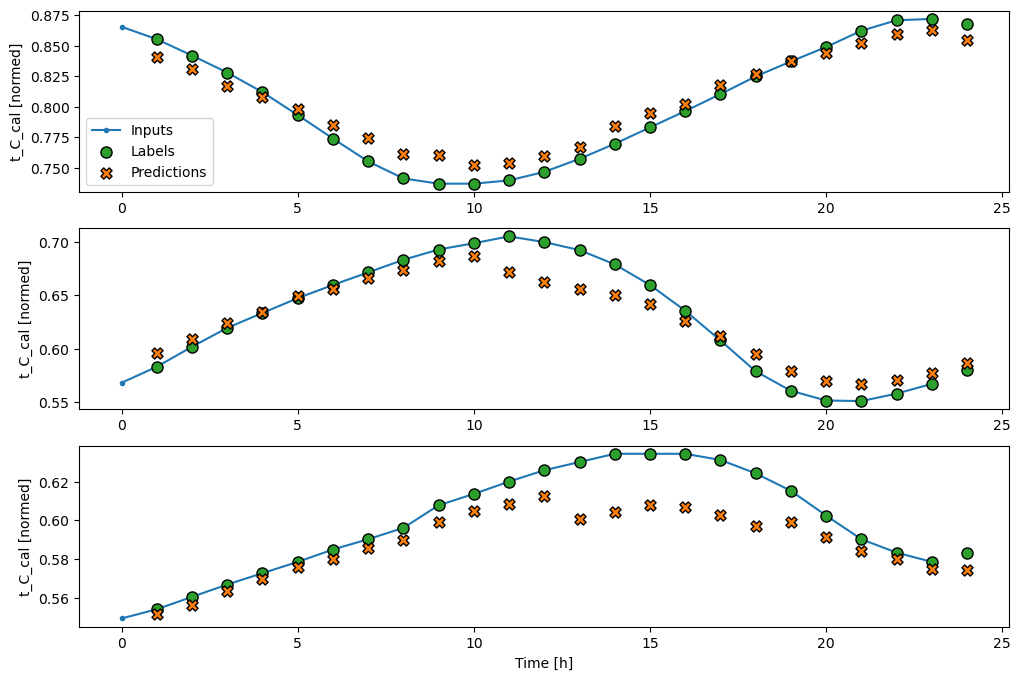

In [26]:
wide_window.plot(linear)

## LSTM

In [27]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(30, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [28]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

18/18 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021


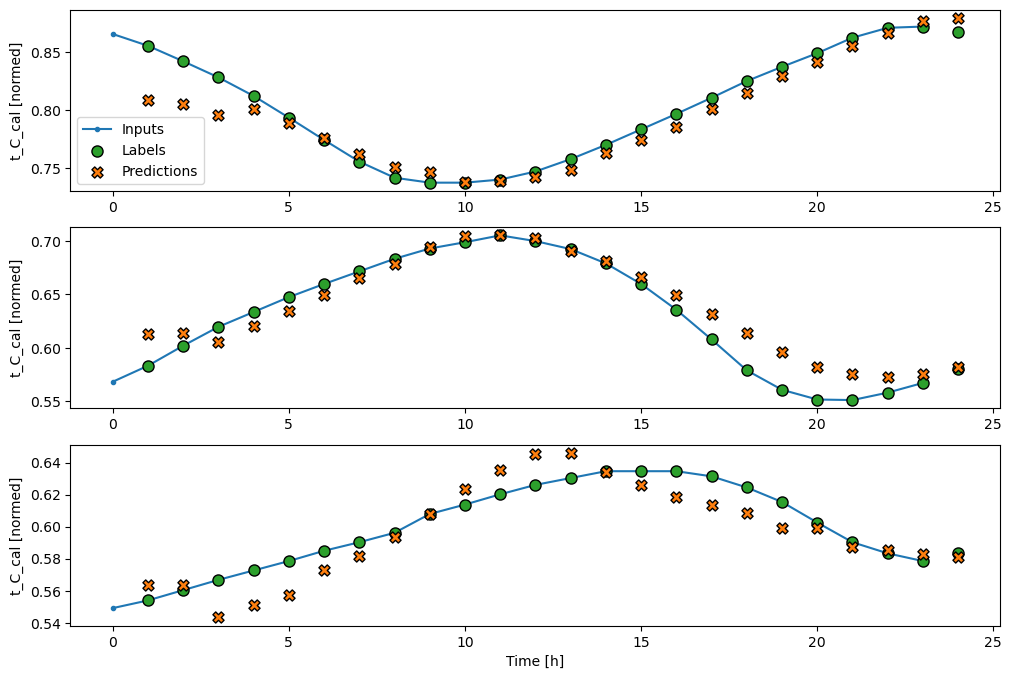

In [29]:
wide_window.plot(lstm_model)

## Rendimiento

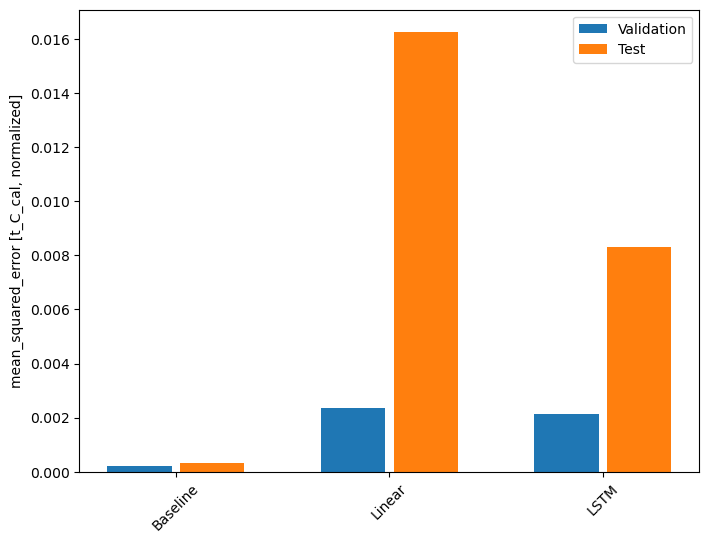

In [30]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [t_C_cal, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Modelos de varios pasos

## Ventana de datos de 24 horas en el futuro

t_C_cal   h_C_cal   t_L_cal   h_L_cal  mes      hora
0     0.000000  0.014107  0.000000  0.048303  1.0  0.528986
1     0.002671  0.007053  0.008202  0.061477  1.0  0.485507
2     0.011218  0.002351  0.015721  0.048303  1.0  0.442029
3     0.032051  0.028409  0.026658  0.052695  1.0  0.380435
4     0.046474  0.035528  0.034860  0.061477  1.0  0.329710
...        ...       ...       ...       ...  ...       ...
2085  0.625534  0.373041  0.630895  0.118563  0.4  0.250000
2086  0.640491  0.384796  0.635680  0.114172  0.4  0.206522
2087  0.655449  0.403605  0.639098  0.114172  0.4  0.159420
2088  0.670406  0.413009  0.639098  0.109780  0.4  0.112319
2089  0.683761  0.417712  0.639098  0.114172  0.4  0.068841

[2090 rows x 6 columns]

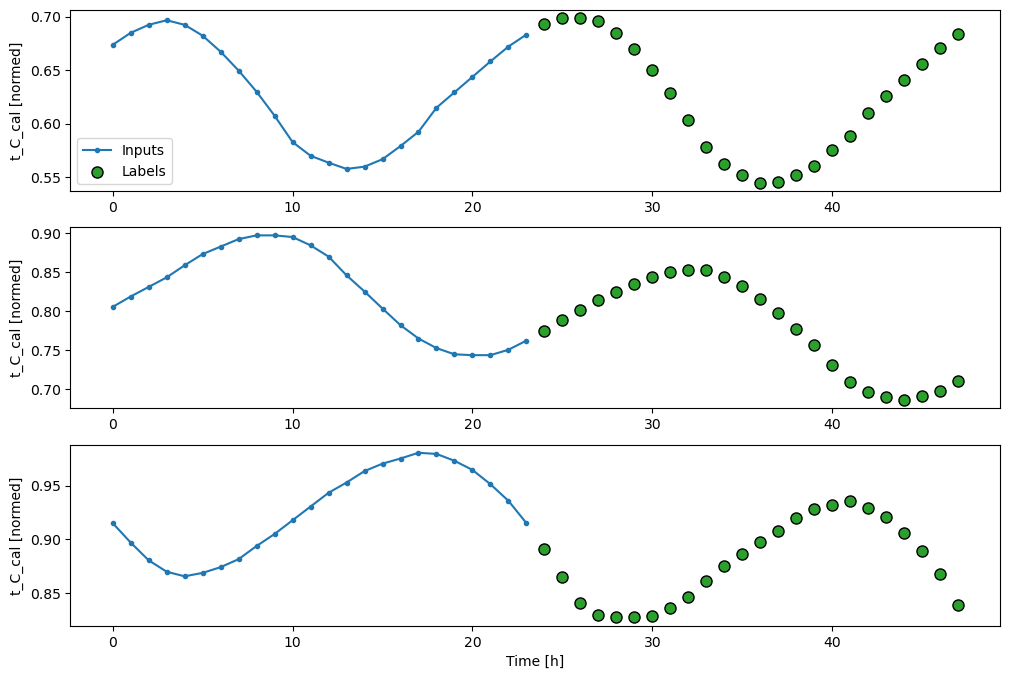

In [31]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window.train_df

In [32]:
multi_val_performance = {}
multi_performance = {}

In [33]:
multi_window.train_df

t_C_cal   h_C_cal   t_L_cal   h_L_cal  mes      hora
0     0.000000  0.014107  0.000000  0.048303  1.0  0.528986
1     0.002671  0.007053  0.008202  0.061477  1.0  0.485507
2     0.011218  0.002351  0.015721  0.048303  1.0  0.442029
3     0.032051  0.028409  0.026658  0.052695  1.0  0.380435
4     0.046474  0.035528  0.034860  0.061477  1.0  0.329710
...        ...       ...       ...       ...  ...       ...
2085  0.625534  0.373041  0.630895  0.118563  0.4  0.250000
2086  0.640491  0.384796  0.635680  0.114172  0.4  0.206522
2087  0.655449  0.403605  0.639098  0.114172  0.4  0.159420
2088  0.670406  0.413009  0.639098  0.109780  0.4  0.112319
2089  0.683761  0.417712  0.639098  0.114172  0.4  0.068841

[2090 rows x 6 columns]

## Lineal

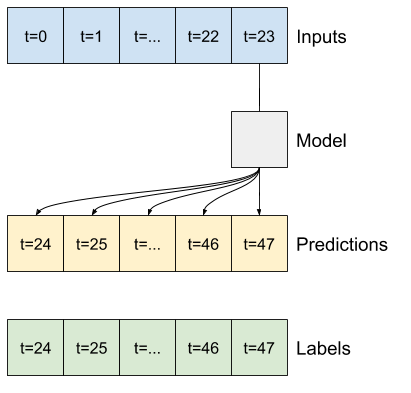

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 0.2110 - mean_squared_error: 0.2110 - val_loss: 0.0838 - val_mean_squared_error: 0.0838
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0971 - mean_squared_error: 0.0971 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0402 - val_mean_squared_error: 0.0402
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0341 - mean_squared_error: 0.0341 - val_loss: 0.0414 - val_mean_squared_error: 0.0414
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 7/200
64/64 [===============

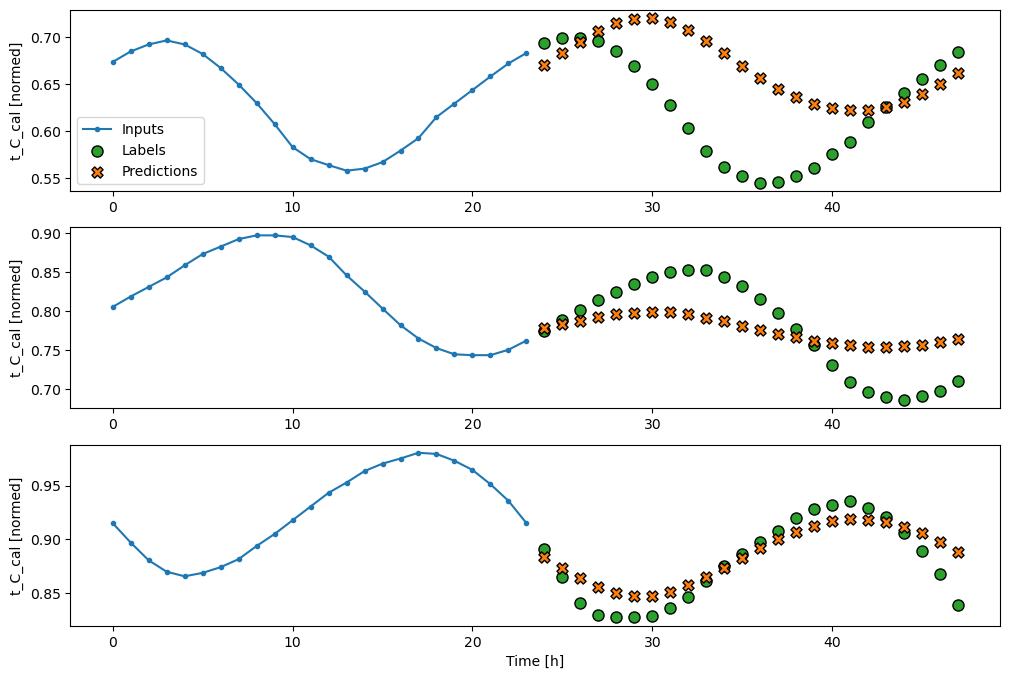

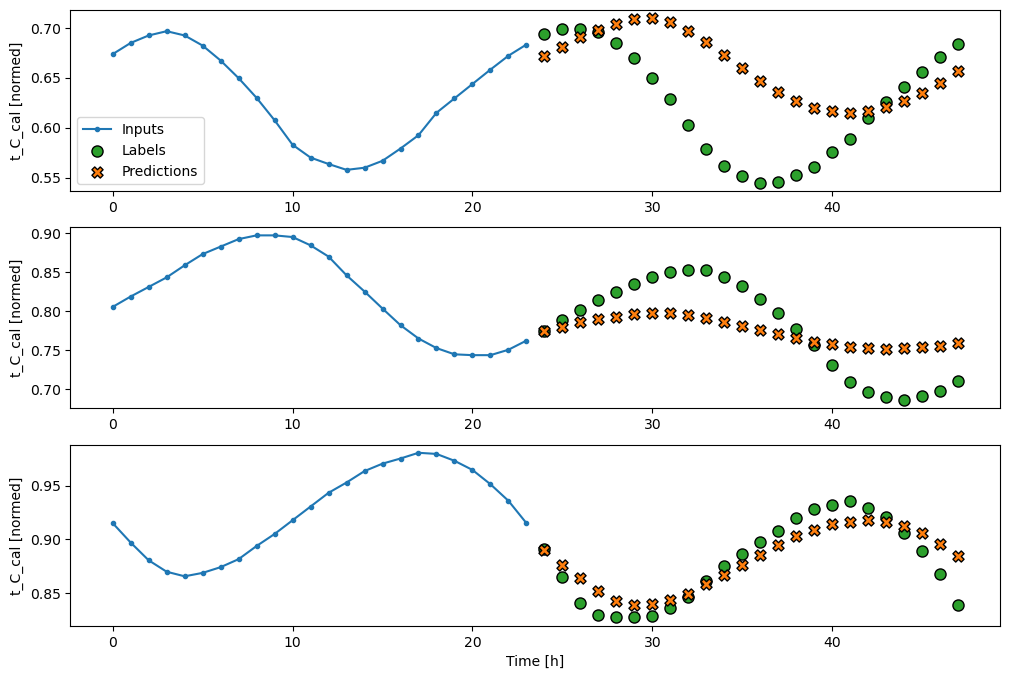

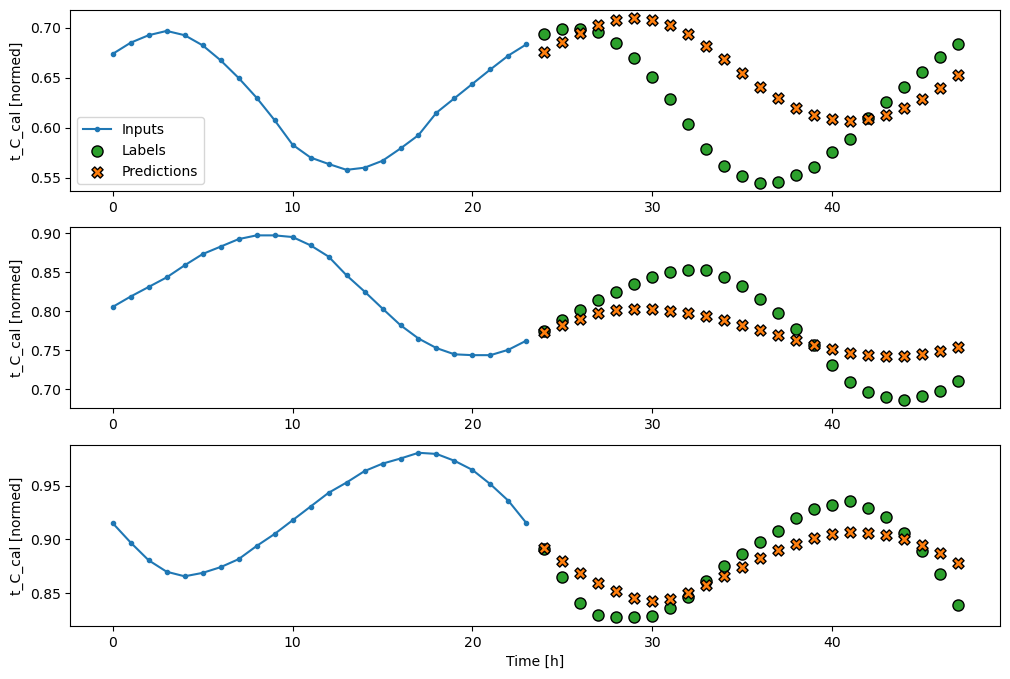

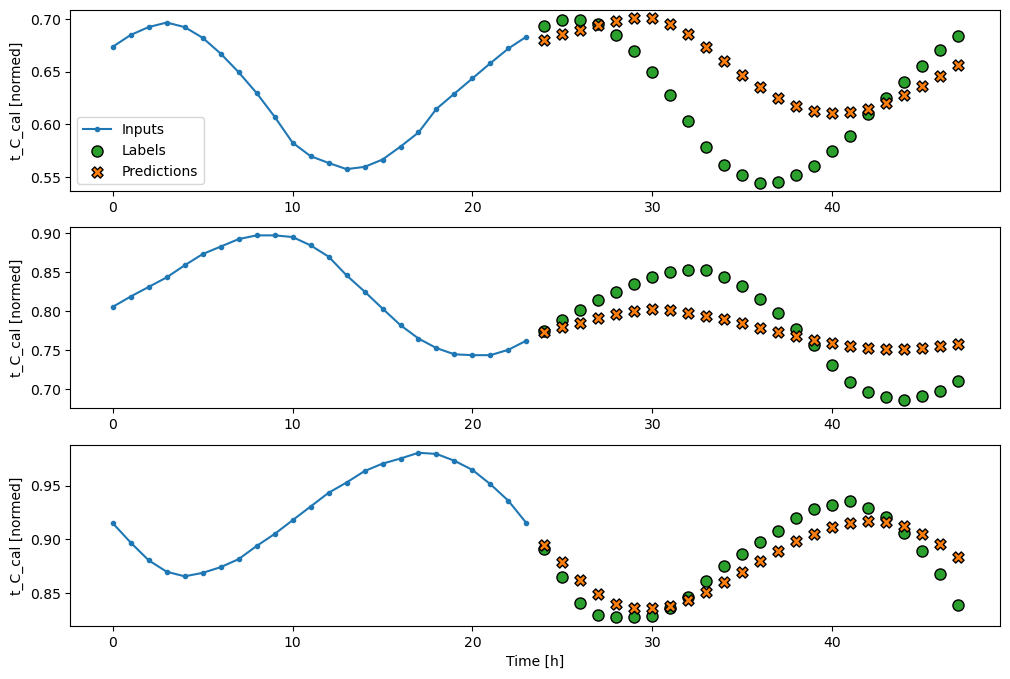

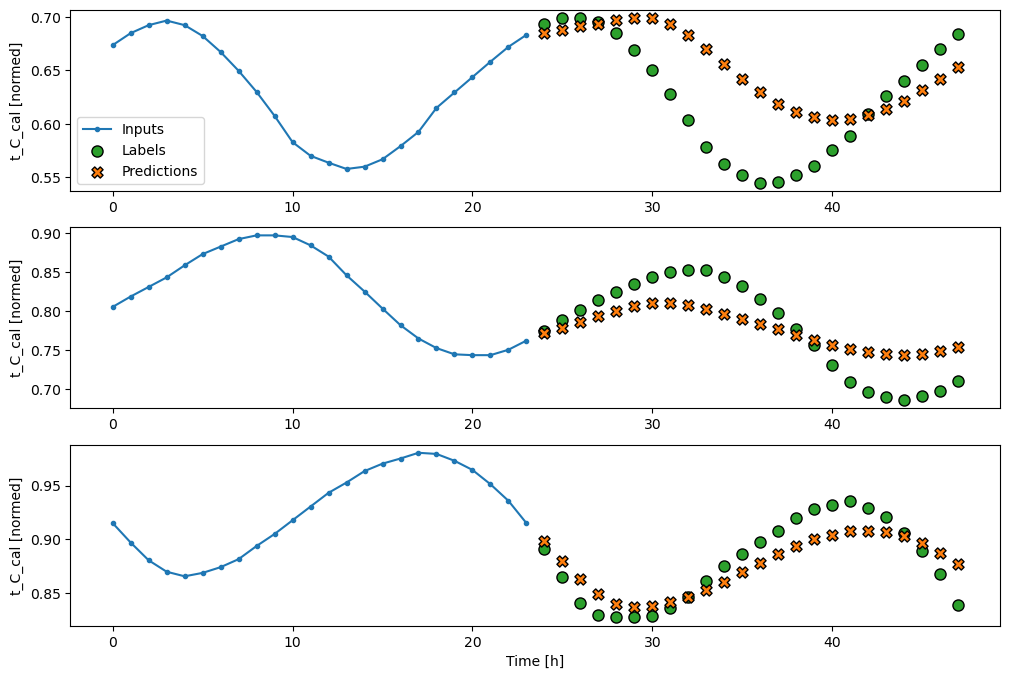

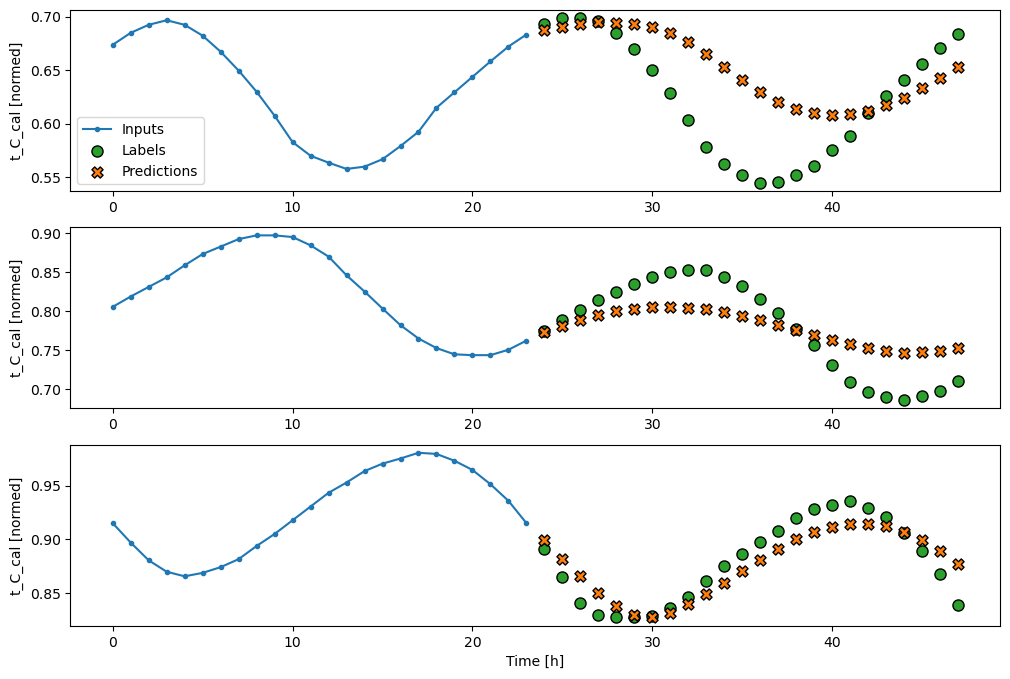

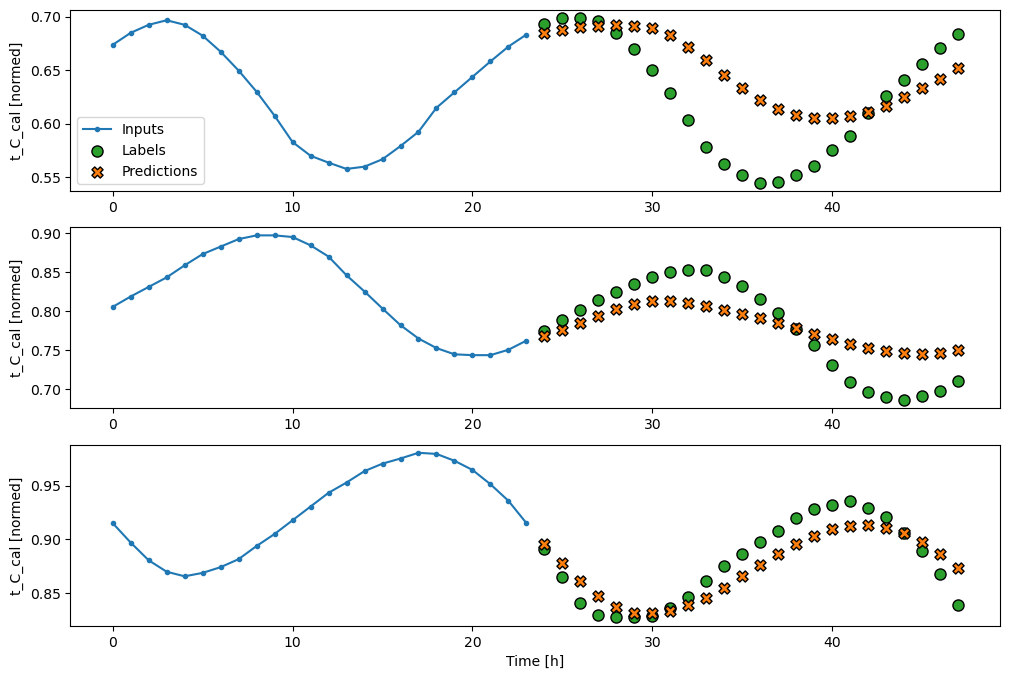

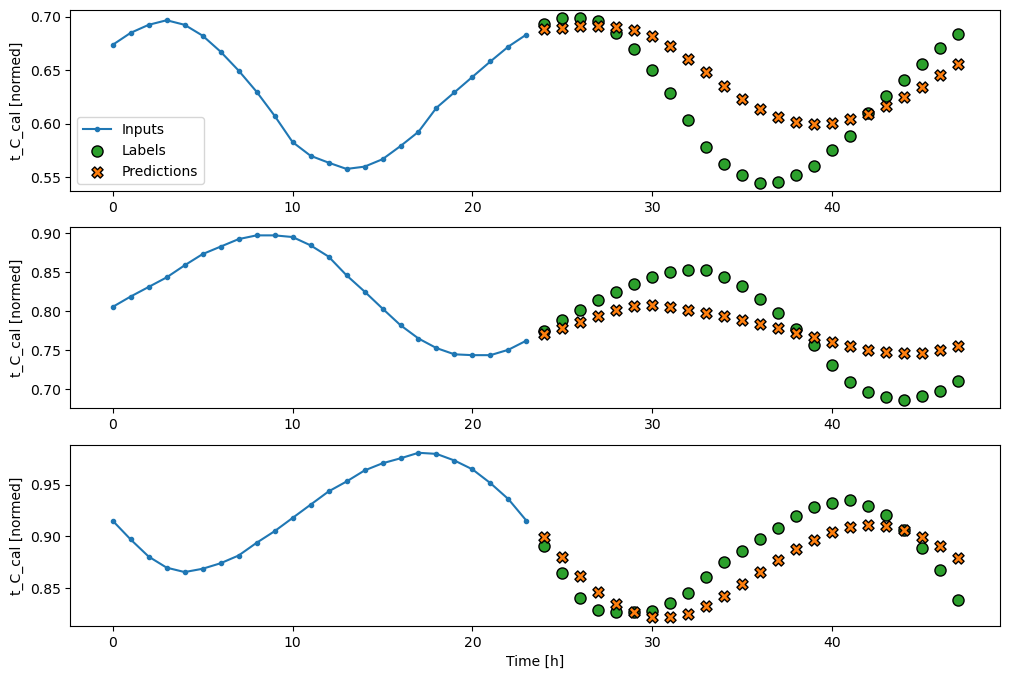

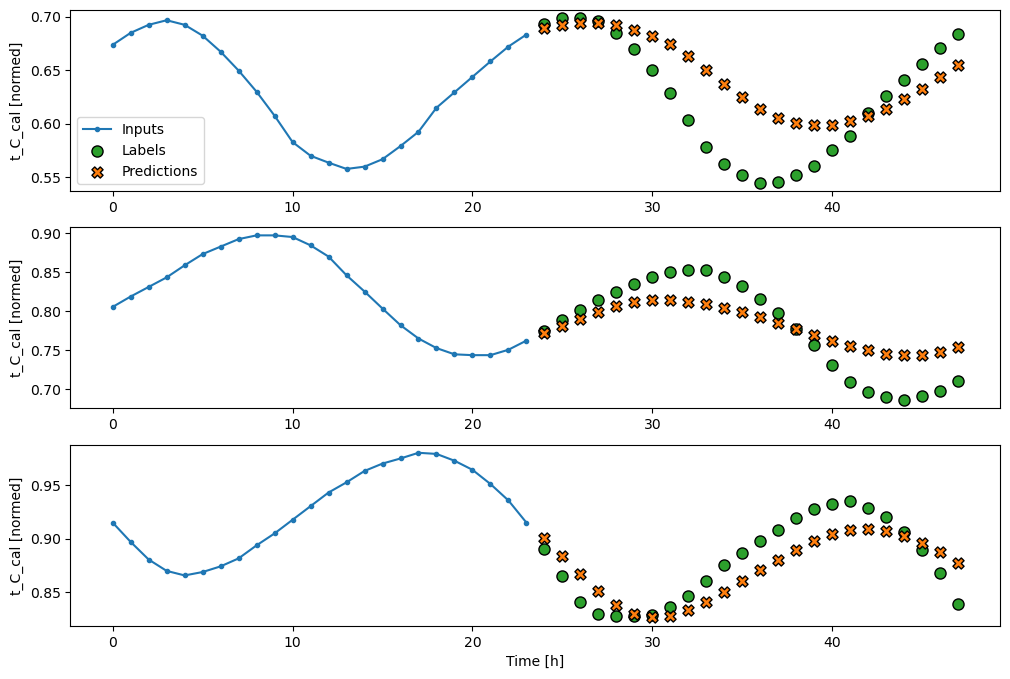

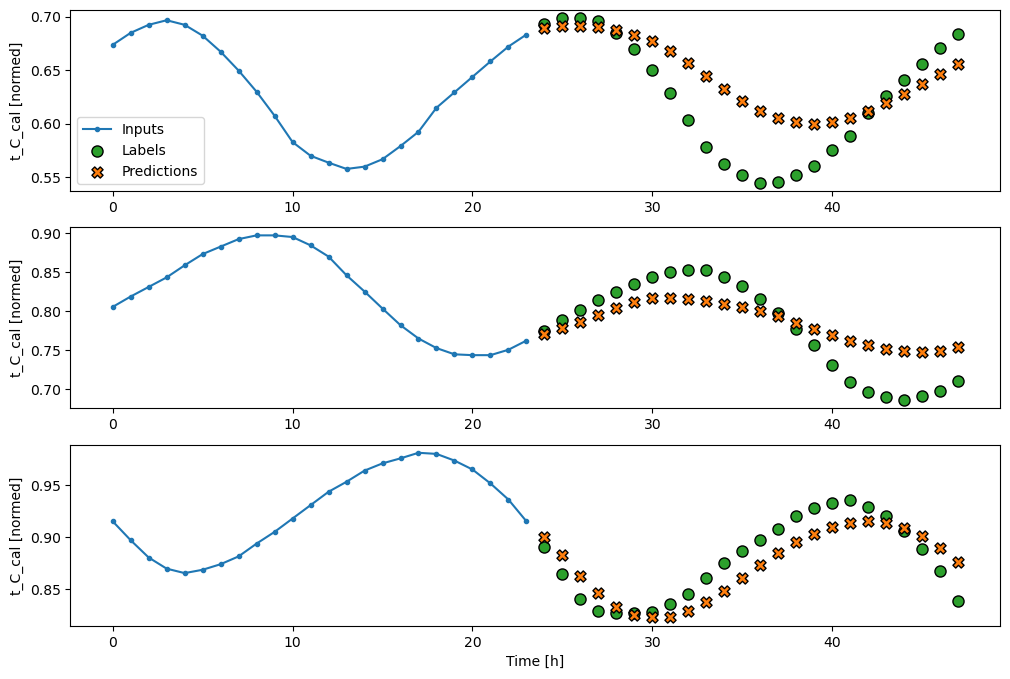

In [34]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])



IPython.display.clear_output()

multi_val_performance['Lineal'] = []
multi_performance['Lineal'] = []
for i in range(10):
    history = compile_and_fit(multi_linear_model, multi_window)

    multi_val_performance['Lineal'].append(multi_linear_model.evaluate(multi_window.val))
    multi_performance['Lineal'].append(multi_linear_model.evaluate(multi_window.test, verbose=0))
    multi_window.plot(multi_linear_model)

# Lineal dense

Epoch 1/200
64/64 [==============================] - 1s 5ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 7/200
64/64 [===============

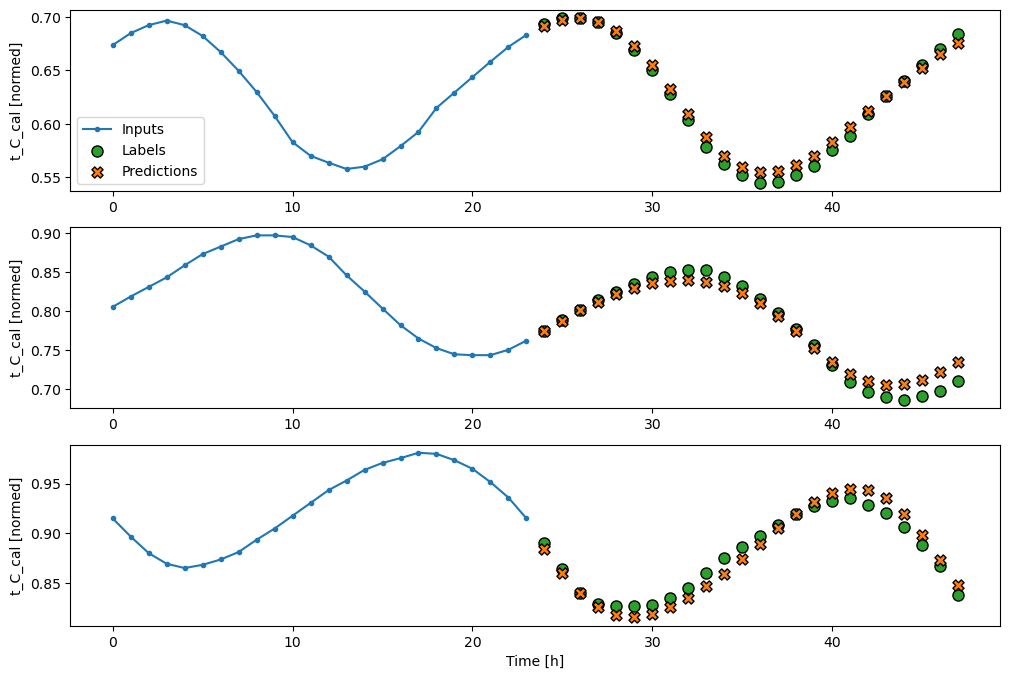

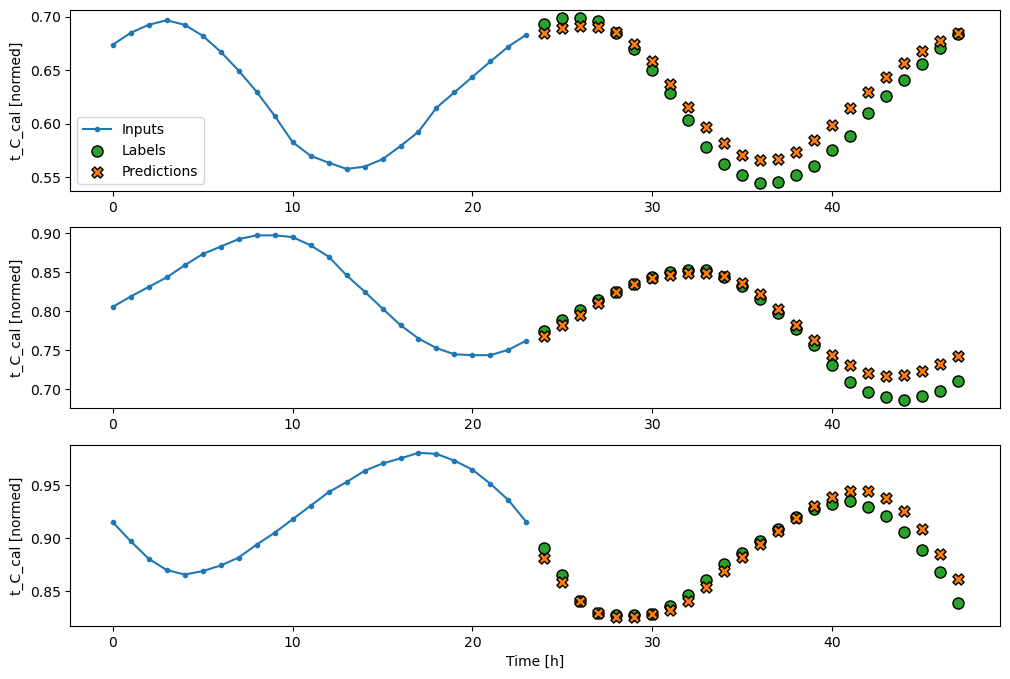

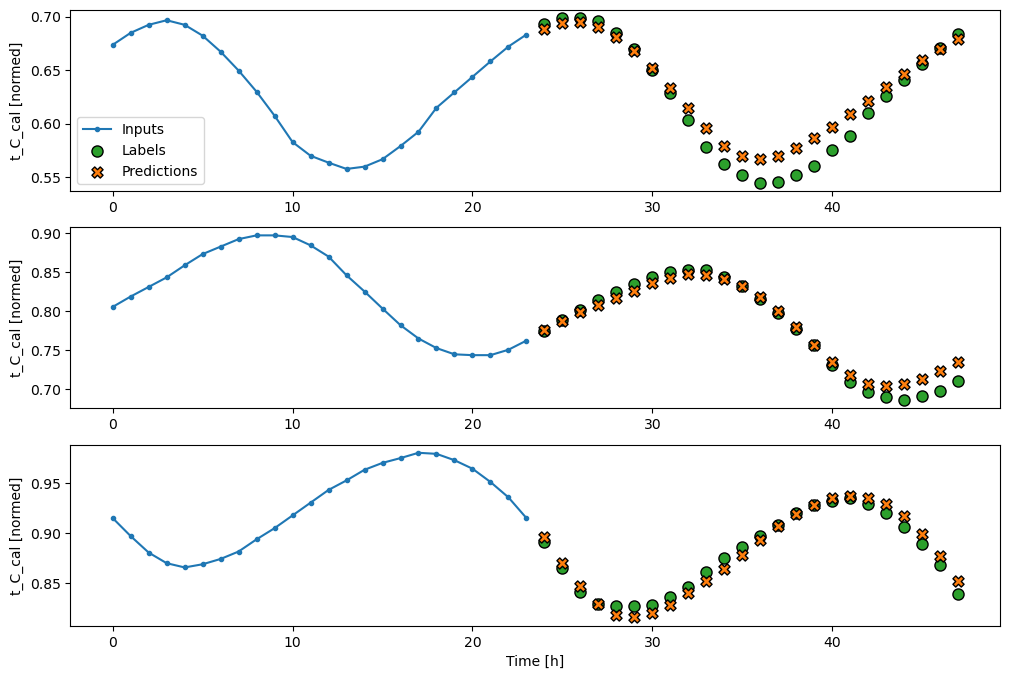

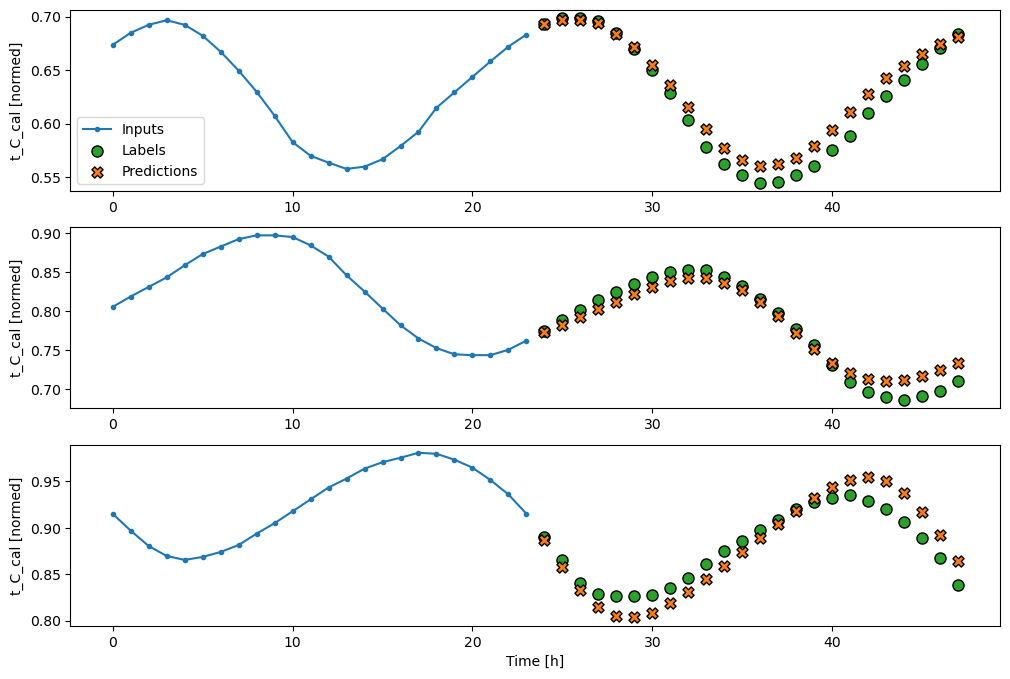

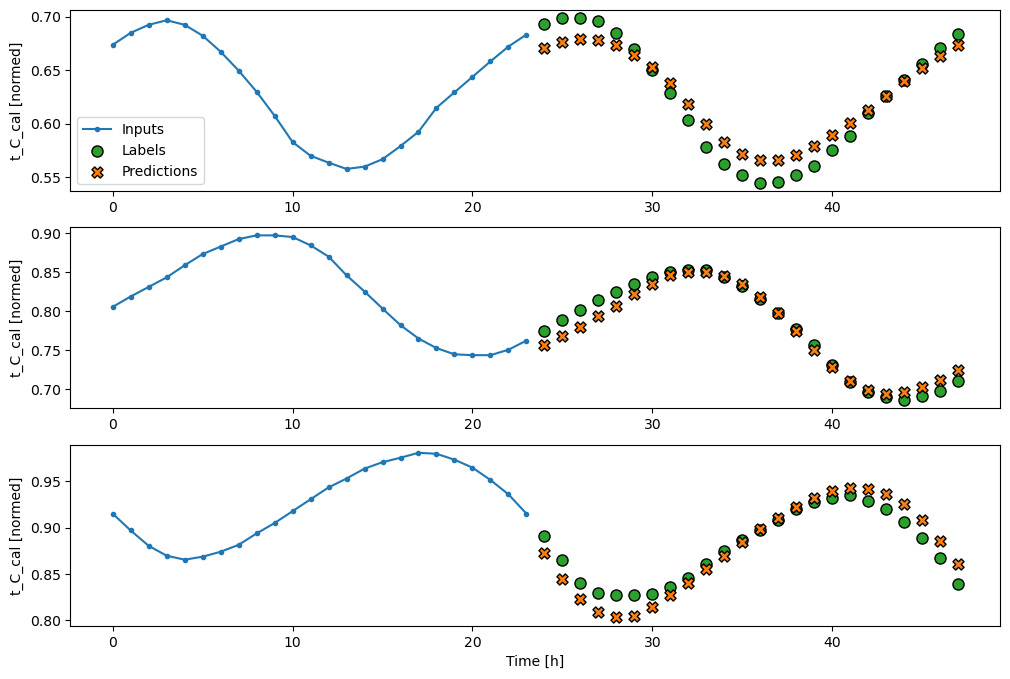

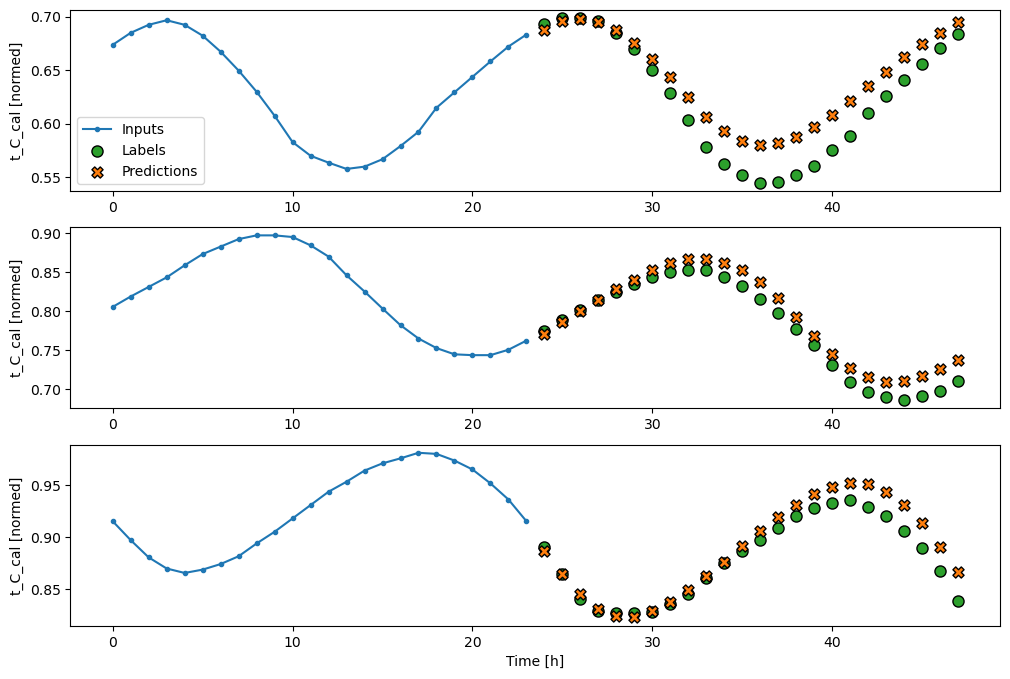

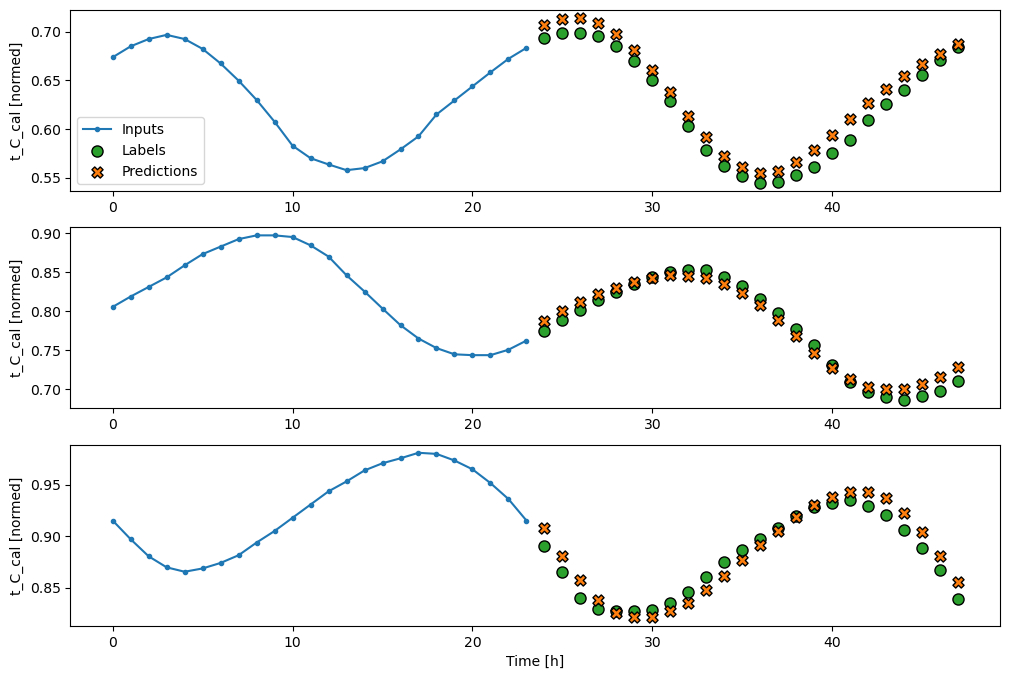

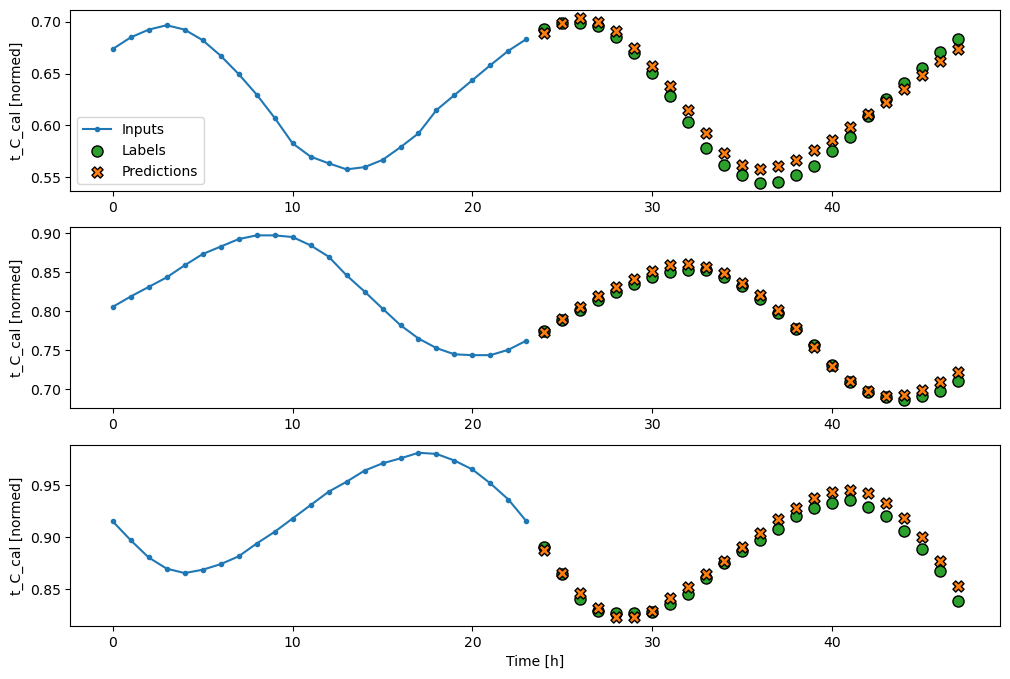

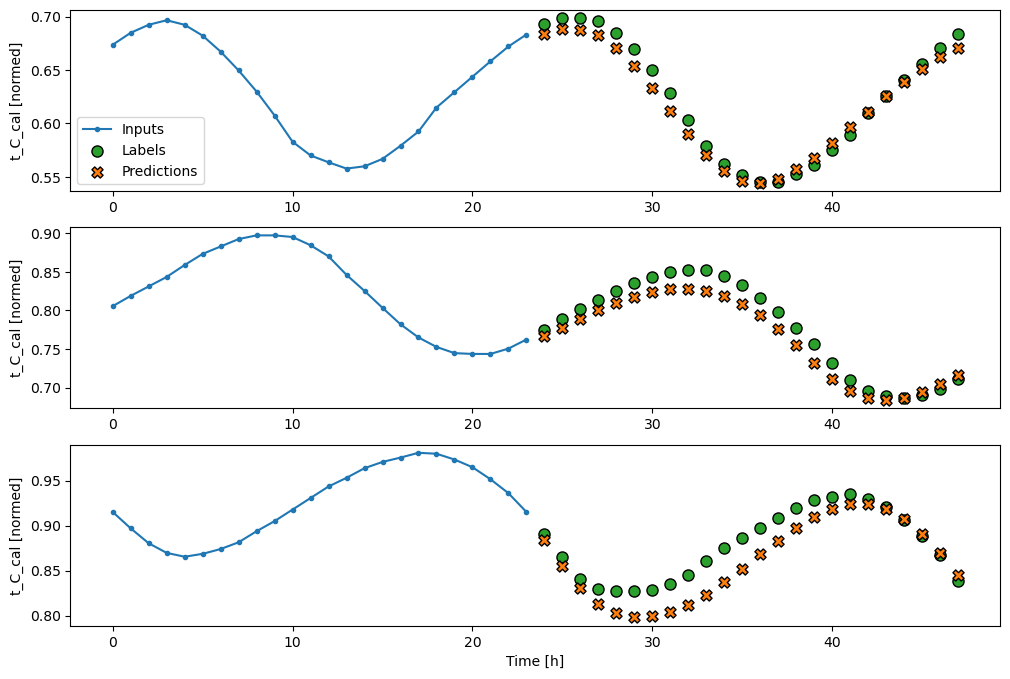

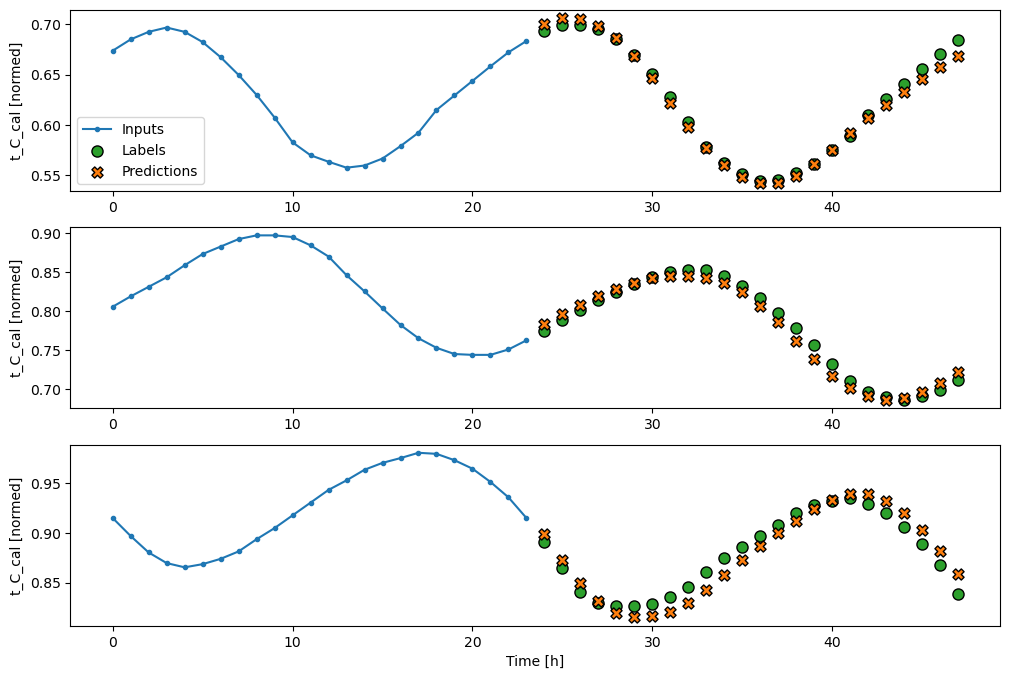

In [35]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

IPython.display.clear_output()

multi_val_performance['Dense'] = []
multi_performance['Dense'] = []

for i in range(10):
    history = compile_and_fit(multi_dense_model, multi_window)

    multi_val_performance['Dense'].append(multi_dense_model.evaluate(multi_window.val))
    multi_performance['Dense'].append(multi_dense_model.evaluate(multi_window.test, verbose=0))
    multi_window.plot(multi_dense_model)

# CNN

Epoch 1/200
64/64 [==============================] - 1s 5ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 7/200
64/64 [===============

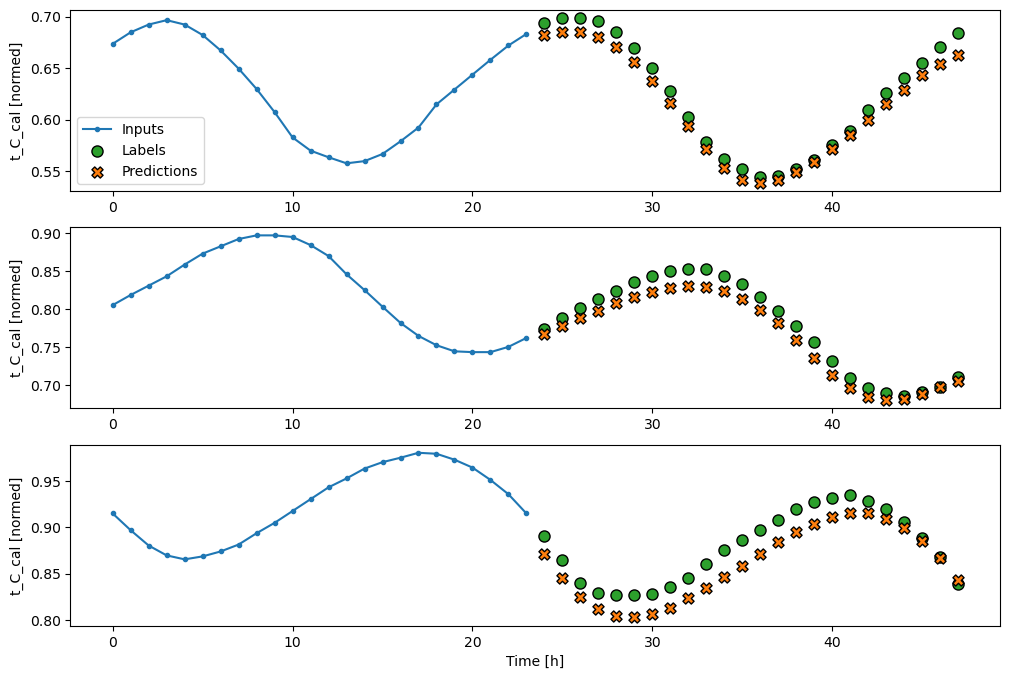

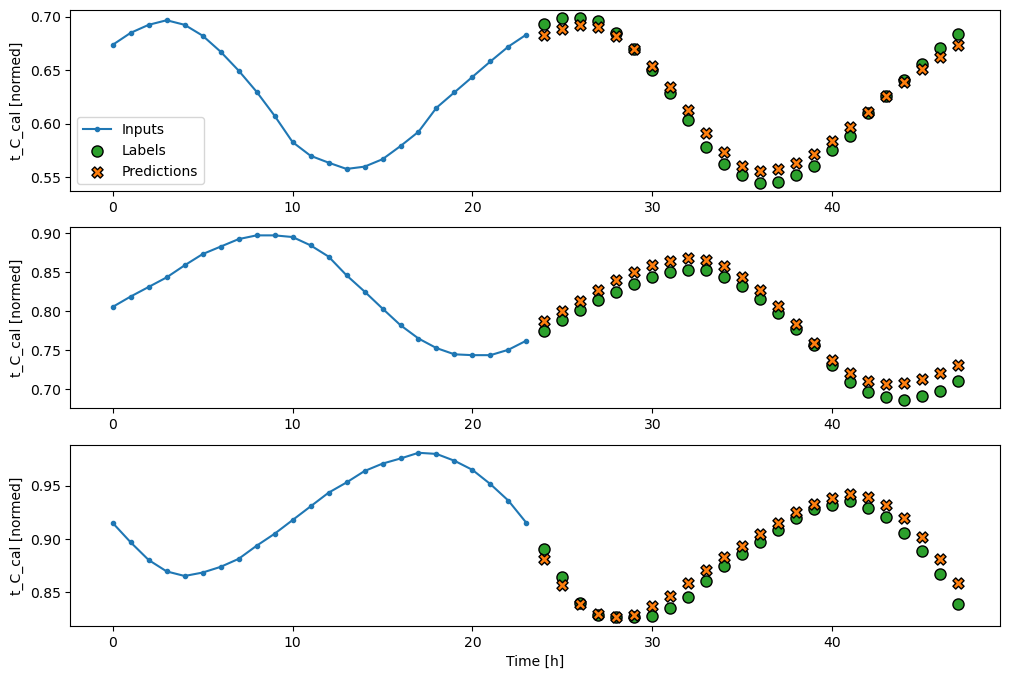

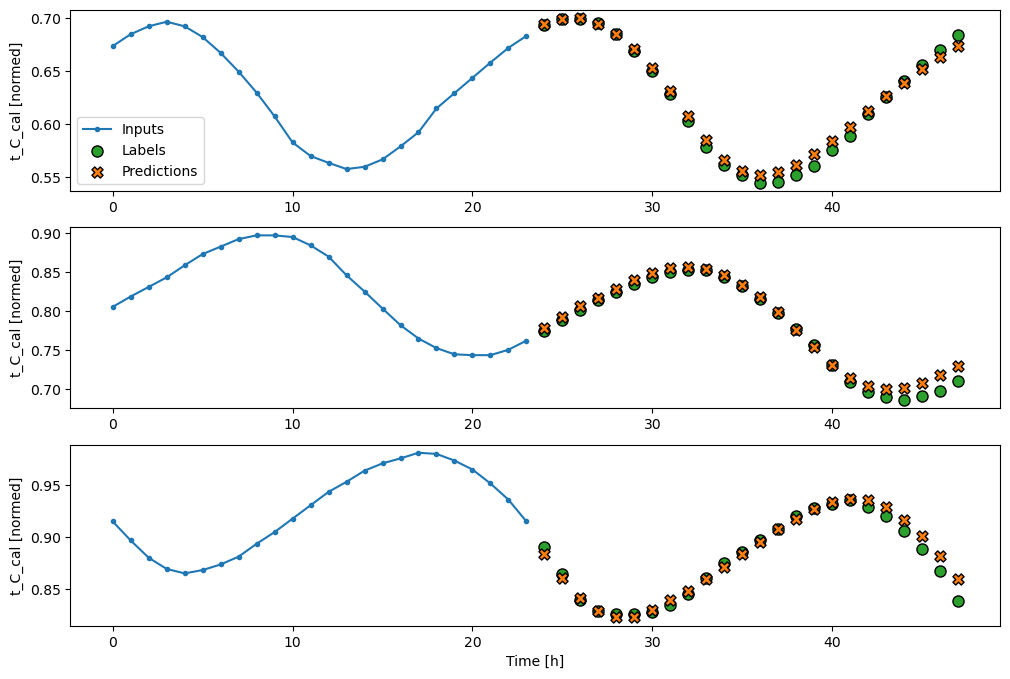

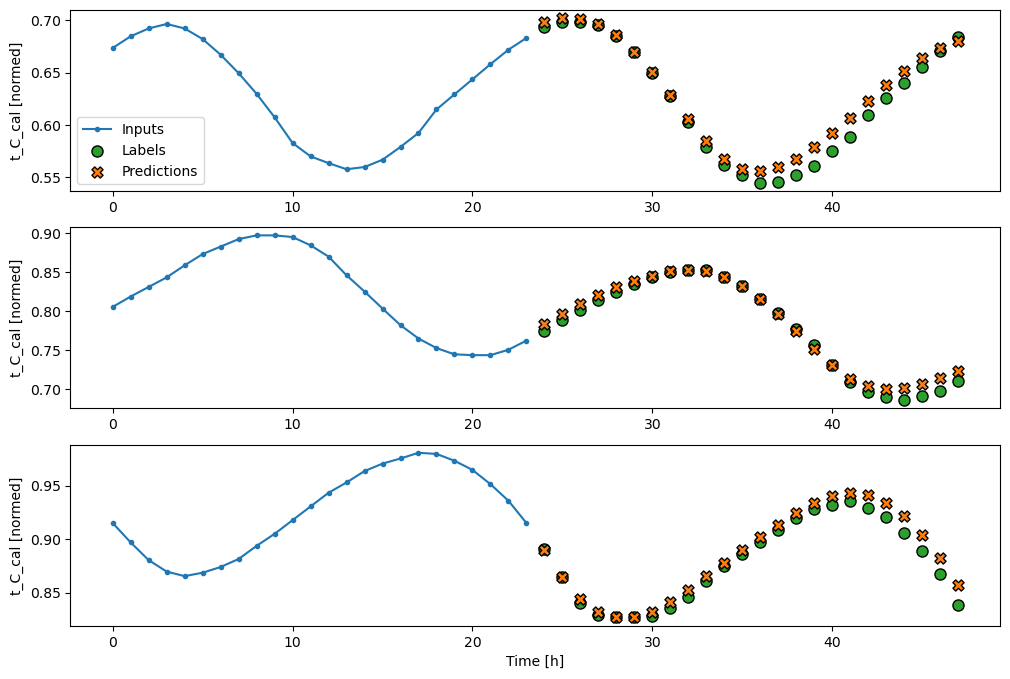

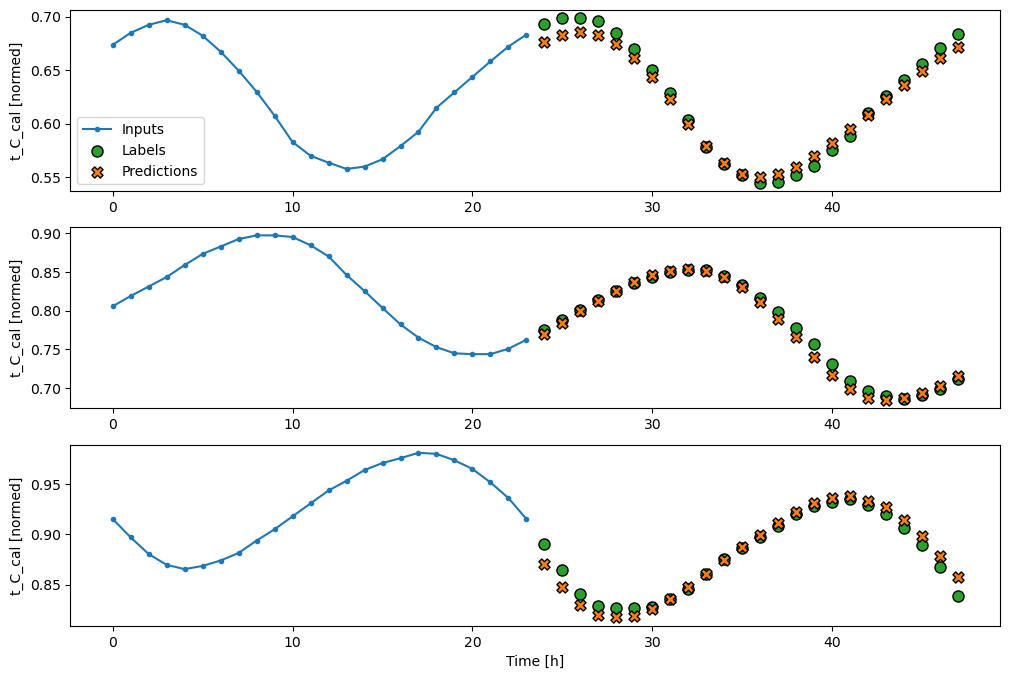

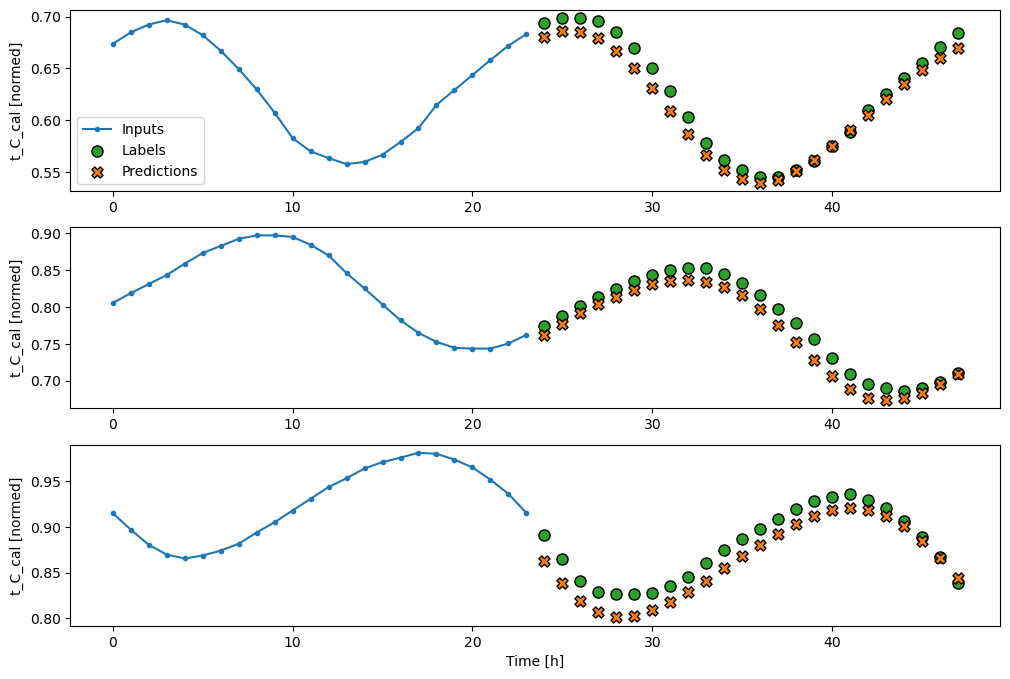

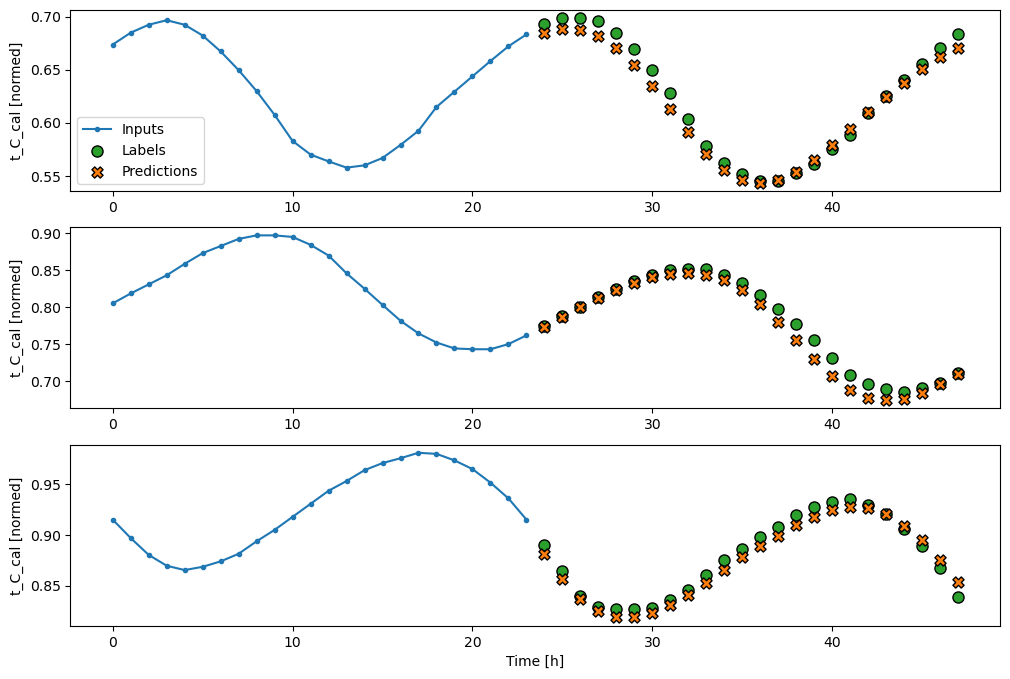

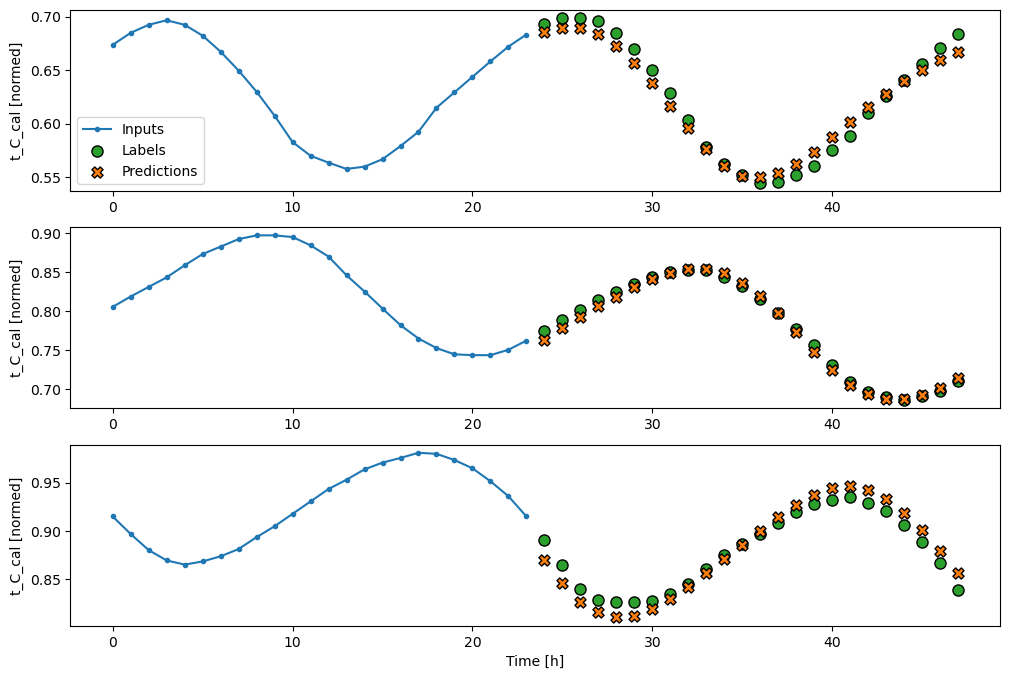

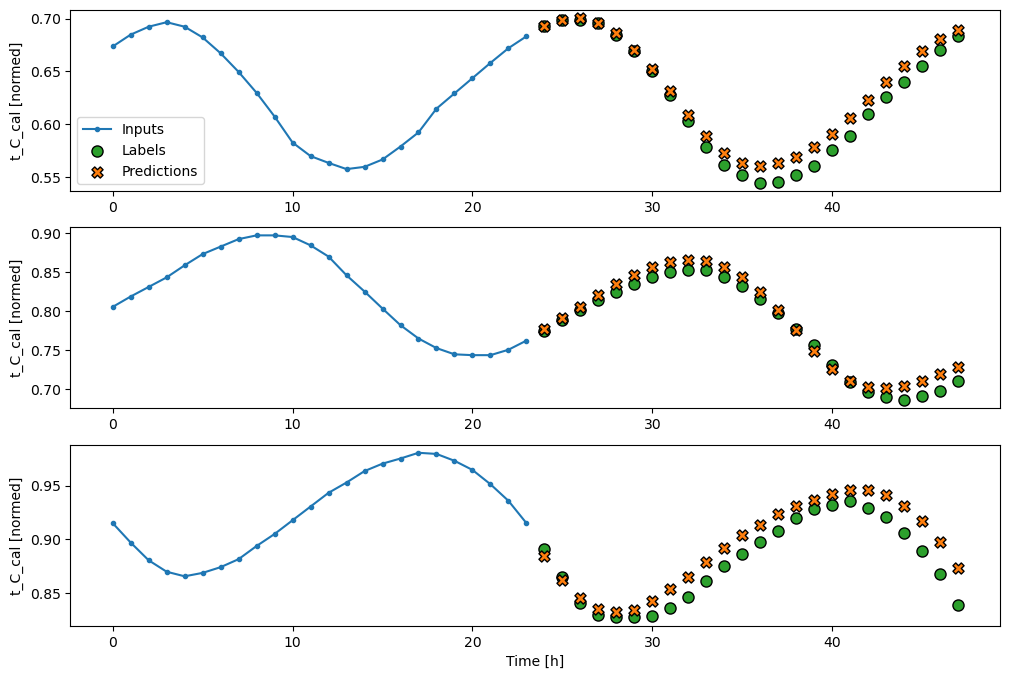

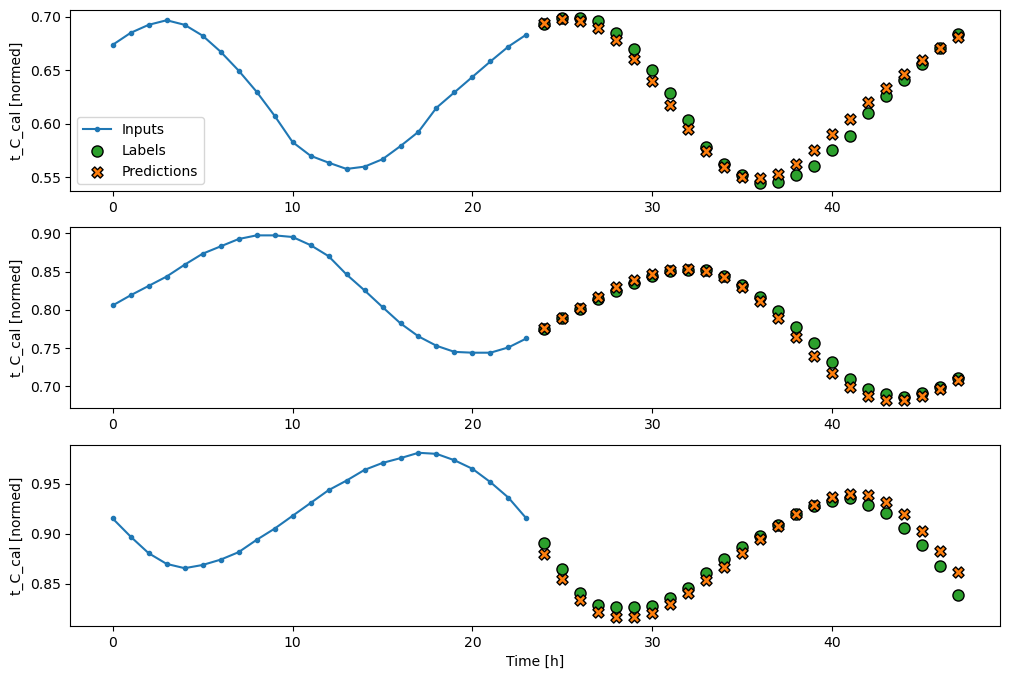

In [36]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

IPython.display.clear_output()

multi_val_performance['CNN'] = []
multi_performance['CNN'] = []

for i in range(10):
    history = compile_and_fit(multi_conv_model, multi_window)

    multi_val_performance['CNN'].append(multi_conv_model.evaluate(multi_window.val))
    multi_performance['CNN'].append(multi_conv_model.evaluate(multi_window.test, verbose=0))
    multi_window.plot(multi_conv_model)

## LSTM recurrente

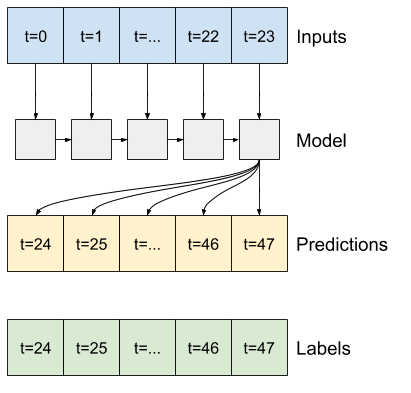

Epoch 1/200
64/64 [==============================] - 3s 14ms/step - loss: 0.1021 - mean_squared_error: 0.1021 - val_loss: 0.0575 - val_mean_squared_error: 0.0575
Epoch 2/200
64/64 [==============================] - 1s 8ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 3/200
64/64 [==============================] - 1s 8ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0565 - val_mean_squared_error: 0.0565
Epoch 4/200
64/64 [==============================] - 1s 8ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 5/200
64/64 [==============================] - 1s 8ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 6/200
64/64 [==============================] - 1s 8ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 7/200
64/64 [==============

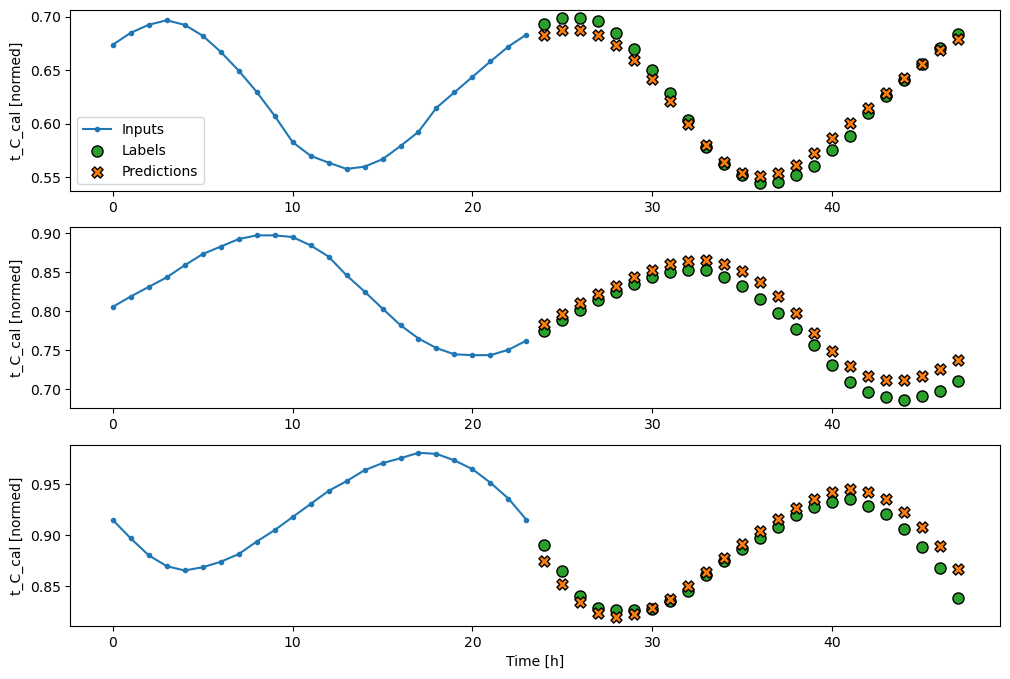

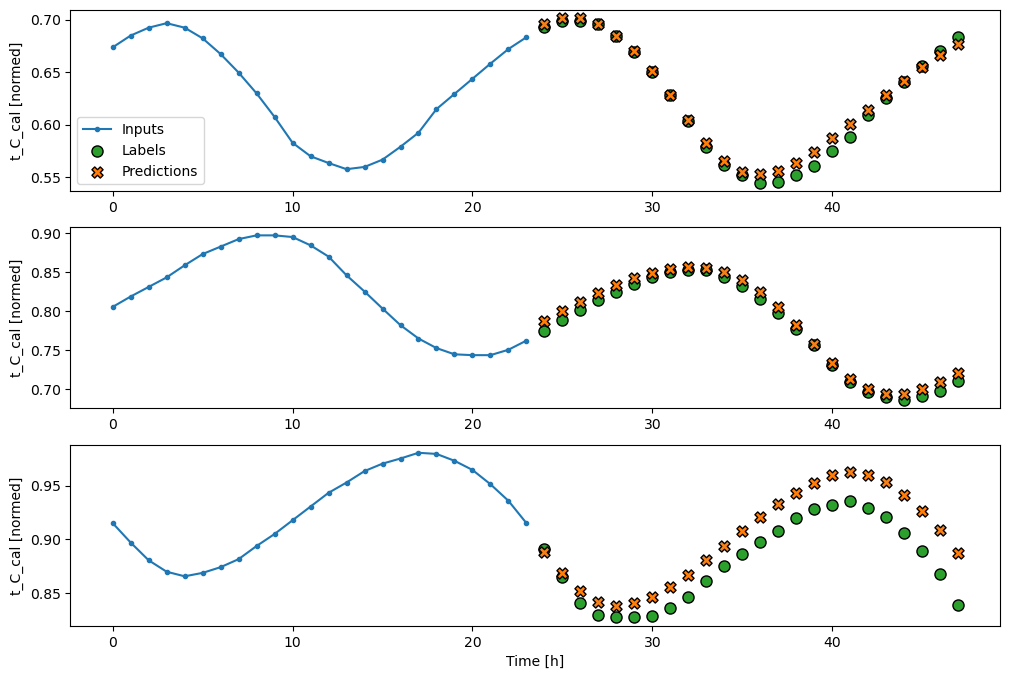

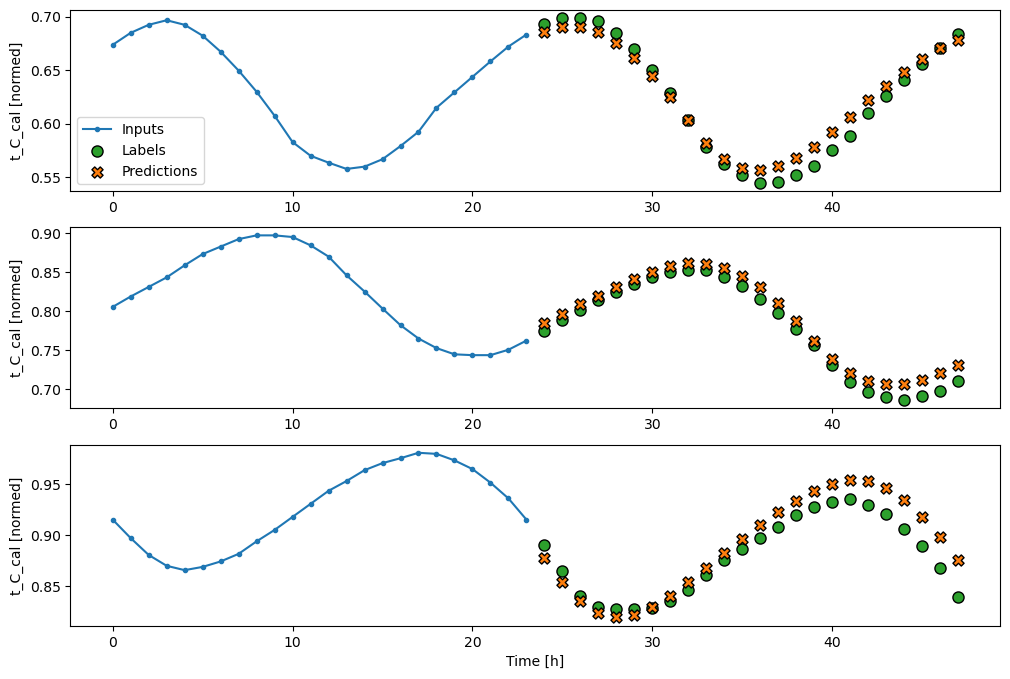

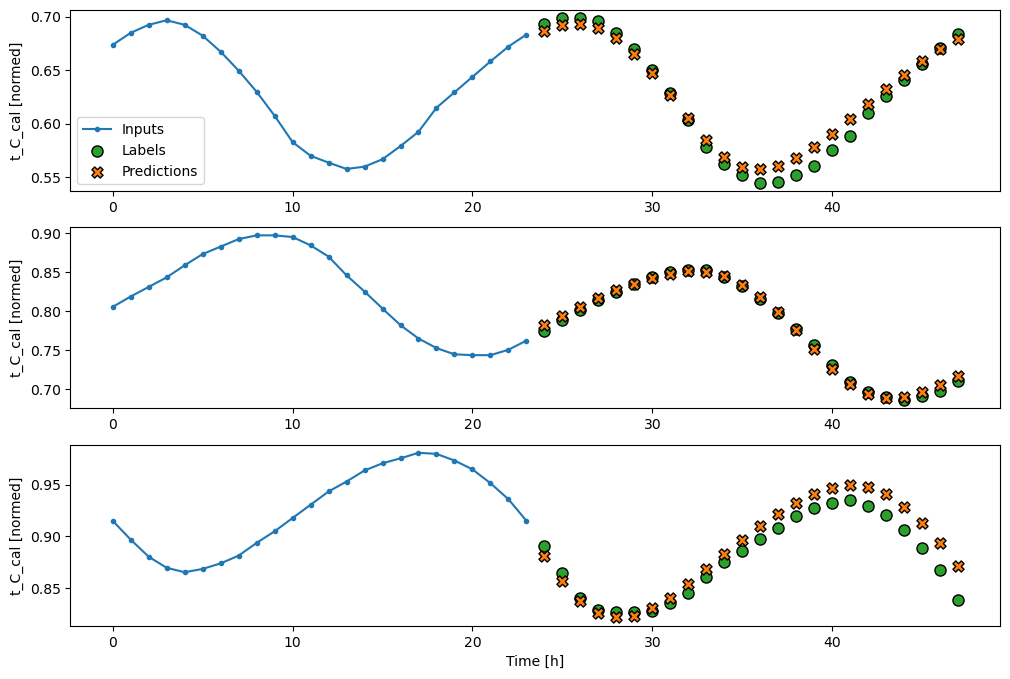

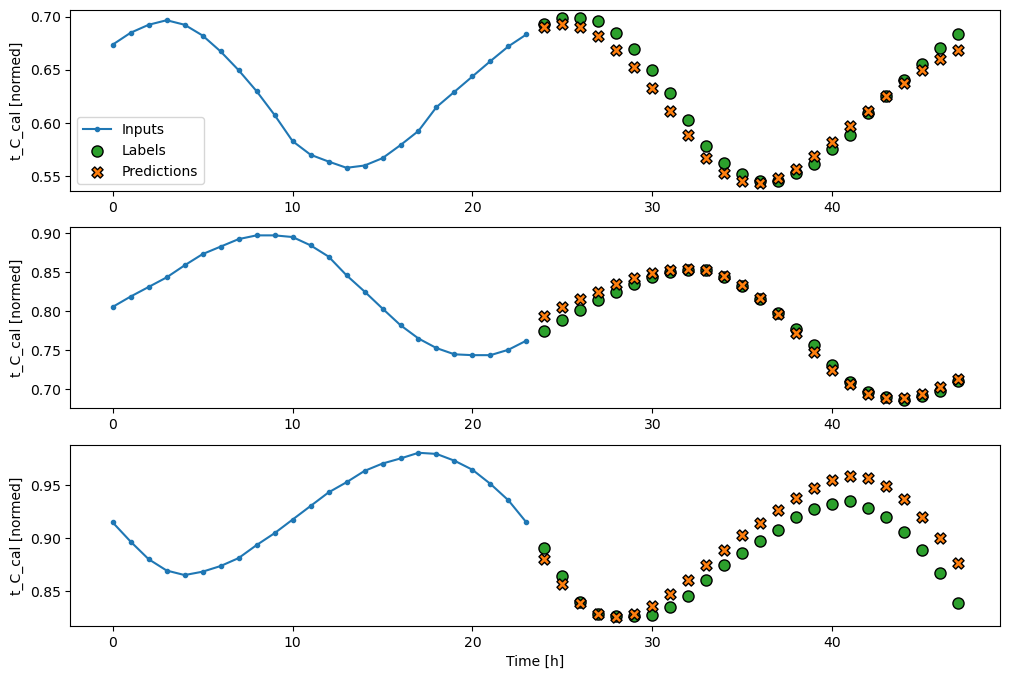

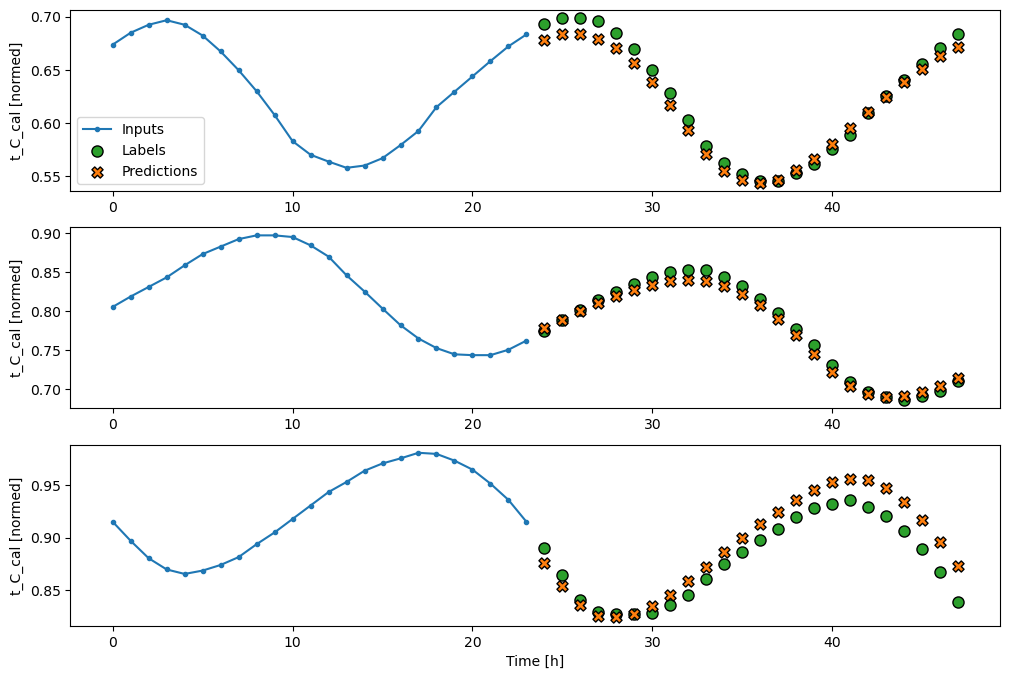

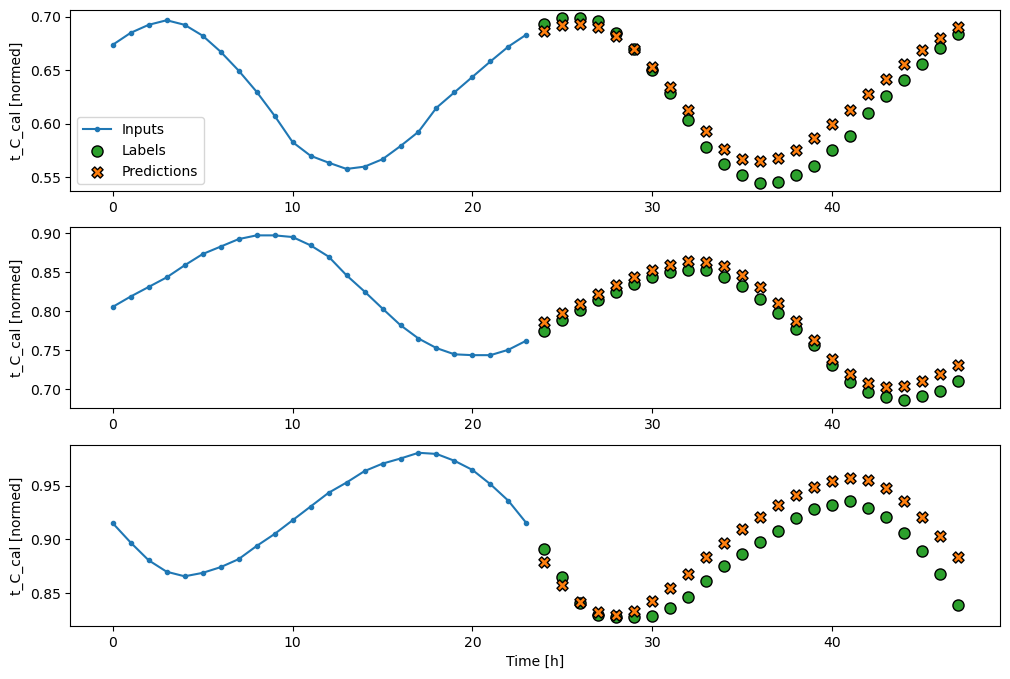

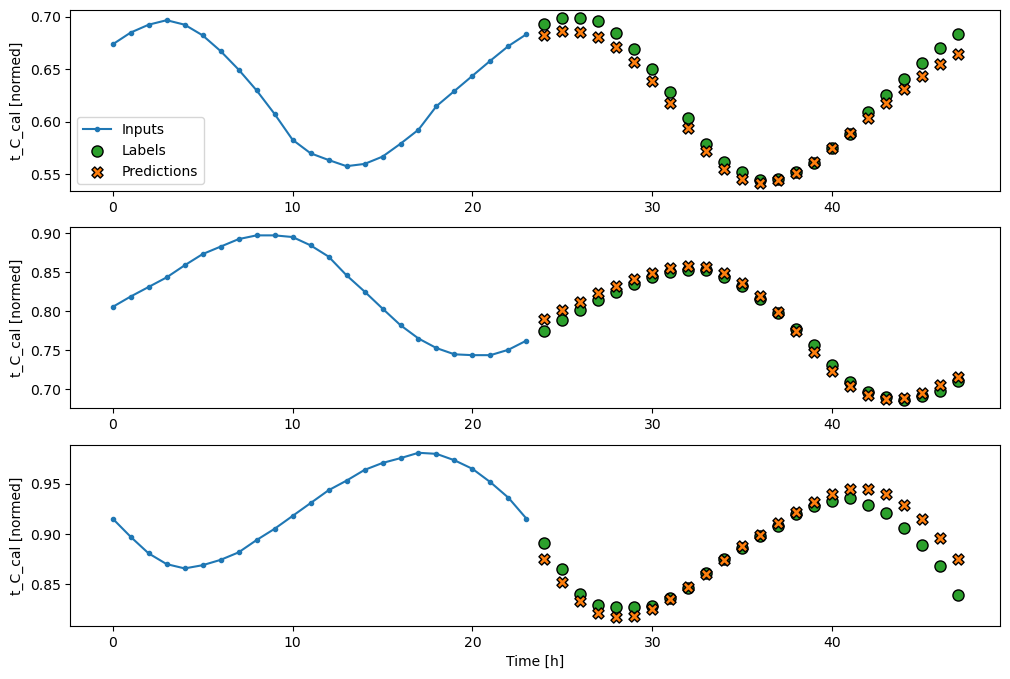

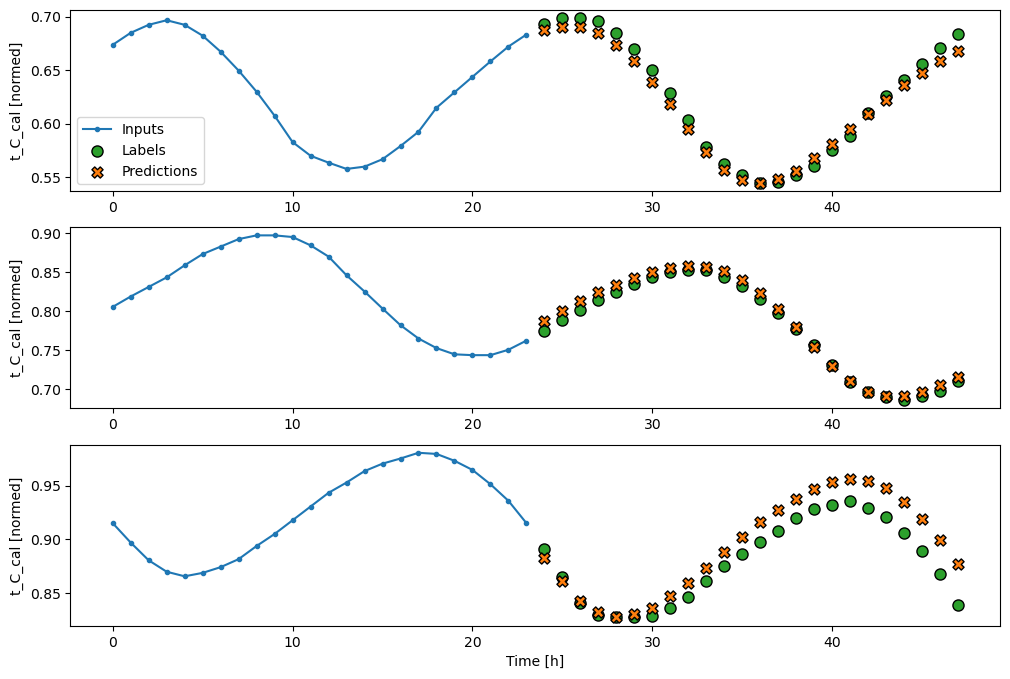

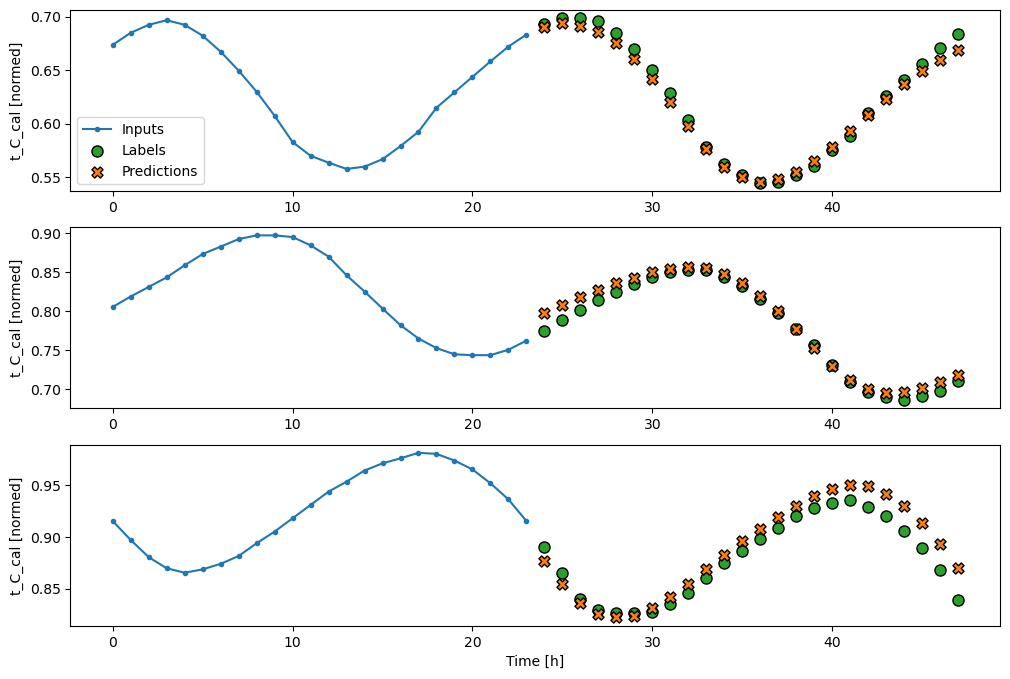

In [37]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])



IPython.display.clear_output()

multi_val_performance['LSTM'] = []
multi_performance['LSTM'] = []

for i in range(10):
    history = compile_and_fit(multi_lstm_model, multi_window)
    
    multi_val_performance['LSTM'].append(multi_lstm_model.evaluate(multi_window.val))
    multi_performance['LSTM'].append(multi_lstm_model.evaluate(multi_window.test, verbose=0))
    multi_window.plot(multi_lstm_model)

## LSTM autorregresivo

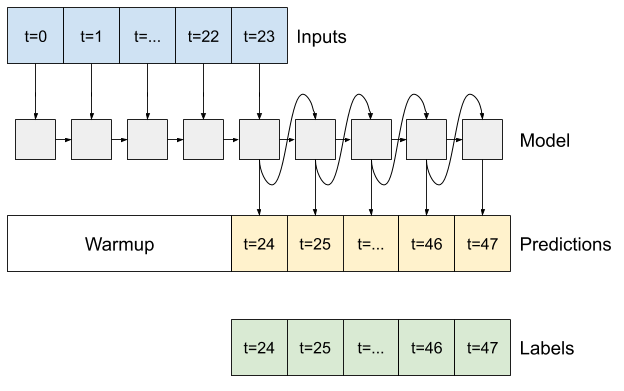

In [38]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [39]:
feedback_model = FeedBack(units=30, out_steps=OUT_STEPS)

In [40]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [41]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/200
64/64 [==============================] - 6s 22ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - val_loss: 0.0679 - val_mean_squared_error: 0.0679
Epoch 2/200
64/64 [==============================] - 1s 12ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0595 - val_mean_squared_error: 0.0595
Epoch 3/200
64/64 [==============================] - 1s 11ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0521 - val_mean_squared_error: 0.0521
Epoch 4/200
64/64 [==============================] - 1s 12ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 5/200
64/64 [==============================] - 1s 12ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 6/200
64/64 [==============================] - 1s 12ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 7/200
64/64 [=========

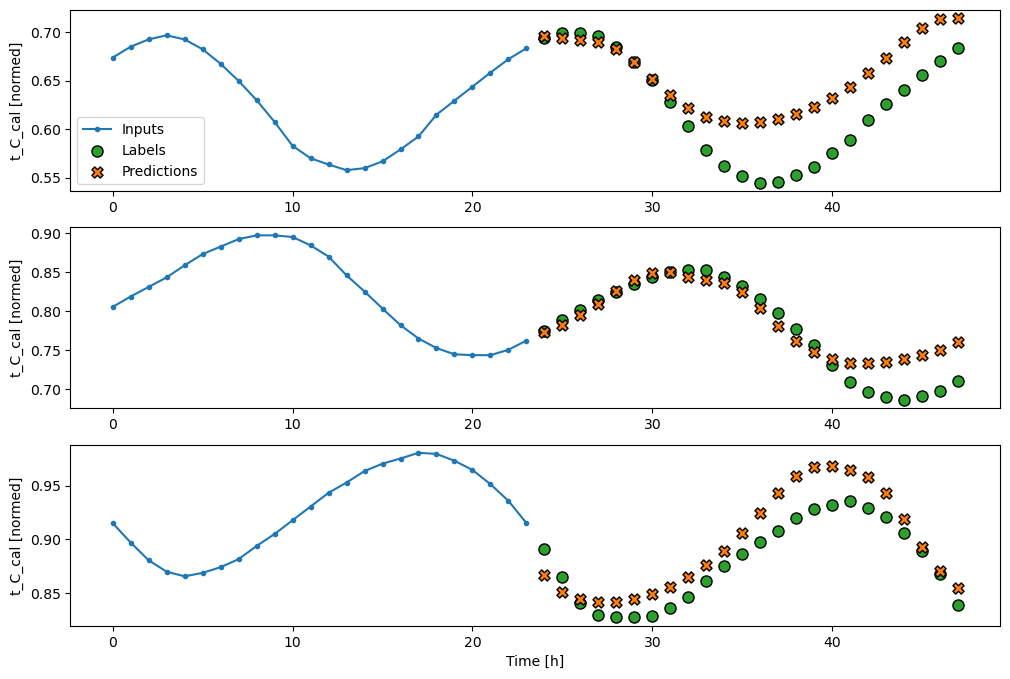

In [42]:
IPython.display.clear_output()

multi_val_performance['AR LSTM'] = []
multi_performance['AR LSTM'] = []

for i in range(1):
    history = compile_and_fit(feedback_model, multi_window)

    multi_val_performance['AR LSTM'].append(feedback_model.evaluate(multi_window.val))
    multi_performance['AR LSTM'].append(feedback_model.evaluate(multi_window.test, verbose=0))
    multi_window.plot(feedback_model)

In [43]:
feedback_model.count_params()

4626

## Rendimiento

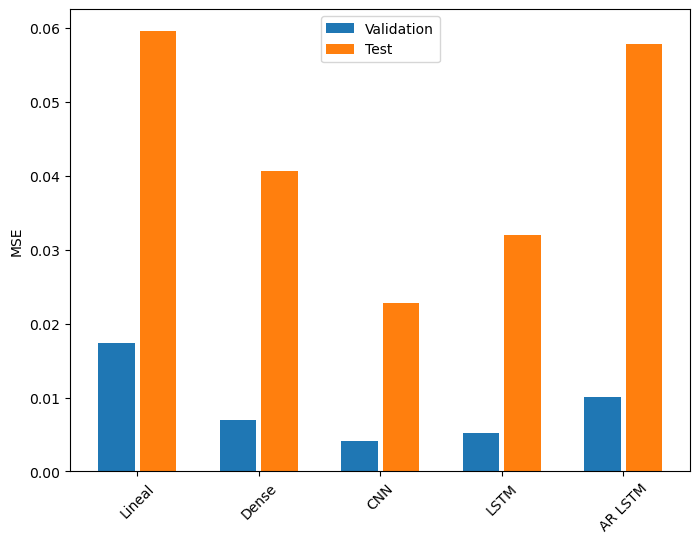

In [44]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')

multi_val_performance['AR LSTM'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_val_performance['AR LSTM'])]
multi_val_performance['LSTM'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_val_performance['LSTM'])]
multi_val_performance['Lineal'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_val_performance['Lineal'])]
multi_val_performance['CNN'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_val_performance['CNN'])]
multi_val_performance['Dense'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_val_performance['Dense'])]

multi_performance['AR LSTM'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_performance['AR LSTM'])]
multi_performance['LSTM'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_performance['LSTM'])]
multi_performance['Lineal'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_performance['Lineal'])]
multi_performance['CNN'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_performance['CNN'])]
multi_performance['Dense'] = [sum(sublista) / len(sublista) for sublista in zip(*multi_performance['Dense'])]

val_mse = [v[metric_index] for v in multi_val_performance.values()]
test_mse = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MSE')
_ = plt.legend()

In [45]:
# normalizado = (dato - min) / (max - min)
# normalizado * (max - min) = dato - min
# normalizado * (max - min) + min = dato

valor = 0.76 * (datos['t_C_cal'].max() - datos['t_C_cal'].min()) + datos['t_C_cal'].min()
valor2 = 0.775 * (datos['t_C_cal'].max() - datos['t_C_cal'].min()) + datos['t_C_cal'].min()
valor3 = 0.79 * (datos['t_C_cal'].max() - datos['t_C_cal'].min()) + datos['t_C_cal'].min()

print(f'Valor 1: {valor}\nValor 2: {valor2}\nValor 3: {valor3}')

Valor 1: 26.556
Valor 2: 26.79
Valor 3: 27.024
